# Exploratory Data Analysis of Epicurious Scrape in a JSON file

This is an idealized workflow for Aaron Chen in looking at data science problems. It likely isn't the best path, nor has he rigidly applied or stuck to this ideal, but he wishes that he worked this way more frequently.

## Purpose: Work through some exploratory data analysis of the Epicurious scrape on stream. Try to write some functions to help process the data.

### Author: Aaron Chen


---

### If needed, run shell commands here

In [1]:
# !python -m spacy download en_core_web_sm

---

## External Resources

List out references or documentation that has helped you with this notebook

### Code
Regex Checker: https://regex101.com/

#### Scikit-learn
1. https://scikit-learn.org/stable/modules/decomposition.html#latent-dirichlet-allocation-lda
2. 

### Data

For this notebook, the data is stored in the repo base folder/data/raw

### Process

Are there steps or tutorials you are following? Those are things I try to list in Process

___

## Import necessary libraries

In [42]:
from datetime import datetime
import matplotlib.pyplot as plt
# import numpy as np
import pandas as pd
from sklearn.base import TransformerMixin
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
# from spacy.lemmatizer import Lemmatizer
from tqdm import tqdm
from typing import Any

---

## Define helper functions

My workflow is to try things with code cells, then when the code cells get messy and repetitive, to convert into helper functions that can be called.

When the helper functions are getting used a lot, it is usually better to convert them to scripts or classes that can be called/instantiated

In [3]:
def custom_lemmatizer(ingredients: list) -> Any: # spacy nlp.Doc
    """This takes in a string representing the recipe and an NLP model and lemmatize with the NER. 
    
    Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    Remove punctuation

    Args:
        ingredients: string
        nlp_mod: spacy model (try built in first, by default called nlp)
    
    Returns:
        nlp.Doc
    """
    lemmas = [token.lemma_ for token in ingredients if (token.is_alpha and token.pos_ not in ["PRON", "VERB"] and len(token.lemma_) > 1)]
    return lemmas
    # return doc

In [4]:
def custom_preprocessor(recipe_ingreds: str) -> list:
    """This function replaces the default sklearn CountVectorizer preprocessor to use spaCy. sklearn CountVectorizer's preprocessor only performs accent removal and lowercasing.

    Args:
        A string to tokenize from a recipe representing the ingredients used in the recipe

    Returns:
        A list of strings that have been de-accented and lowercased to be used in tokenization
    """
    preprocessed = [token for token in nlp(recipe_ingreds)]

    return preprocessed

In [5]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

In [6]:
def concat_matrices_to_df(df, vectorized_ingred_matrix, cv):
    """This function takes in a dataframe and concats the matrix generated by either CountVectorizer or TFIDF-Transformer onto the records so that the recipes can be used for classification purposes.

    Args: 
        df: preprocessed dataframe from preprocess_dataframe
        vectorized_ingred_matrix: sparse csr matrix created from doing fit_transform on the recipe_megalist
     
    Returns:
        A pandas dataframe with the vectorized_ingred_matrix appended as columns to df
    """
    repo_tfidf_df = pd.DataFrame(vectorized_ingred_matrix.toarray(), columns=cv.get_feature_names_out(), index=df.index)
    return pd.concat([df, repo_tfidf_df], axis=1)

In [7]:
def cuisine_namer(text):
    """This function converts redundant and/or rare categories into more common
    ones/umbrella ones.

    In the future, there's a hope that this renaming mechanism will not have
    under sampled cuisine tags.
    """
    if text == "Central American/Caribbean":
        return "Caribbean"
    elif text == "Jewish":
        return "Kosher"
    elif text == "Eastern European/Russian":
        return "Eastern European"
    elif text in ["Spanish/Portuguese", "Greek"]:
        return "Mediterranean"
    elif text == "Central/South American":
        return "Latin American"
    elif text == "Sushi":
        return "Japanese"
    elif text == "Southern Italian":
        return "Italian"
    elif text in ["Southern", "Tex-Mex"]:
        return "American"
    elif text in ["Southeast Asian", "Korean"]:
        return "Asian"
    else:
        return text

### Import local script

I started grouping this in with importing libraries, but putting them at the bottom of the list

In [8]:
import project_path

import src.dataframe_preprocessor as dfpp

---

## Define global variables 
### Remember to refactor these out, not ideal

In [9]:
data_path = "../../data/recipes-en-201706/epicurious-recipes_m2.json"
food_stopwords_path = "../../food_stopwords.csv"

---

## Running Commentary

1. I used numbered lists to keep track of things I noticed

### To Do

1. Try to determine consistency of nested data structures
   1. Is the photoData or number of things inside photoData the same from record to record
   2. What about for tag?

Data wasn't fully consistent but logic in helper function helped handle nulls

2. How to handle nulls?
   1. Author      Filled in with "Missing Author"
   2. Tag         Filled in with "Missing Cuisine"
3. ~~Convert pubDate to actual timestamp~~  
4. ~~Convert ScrapeDate to actual timestamp~~
   1. This was ignored as the datestamp was not useful (generally within minutes of the origin of UNIX time)
   
**5. Append new columns for relevant nested structures and unfold them**

6. Determine actual types of `ingredients` and `prepSteps`
7. Continue working through test example of single recipe to feed into spaCy and then sklearn.feature_extraction.text stack
8. Will need to remove numbers, punctuation

---

## Importing and viewing the data as a dataframe

In [10]:
sheeeeeesh = pd.read_json(path_or_buf=data_path) # type:ignore
pd.read_json(data_path, typ='frame') # type:ignore

dfpp.preprocess_dataframe(df=sheeeeeesh) # type:ignore
sheeeeeesh['variable'] = sheeeeeesh['cuisine_name'].apply(cuisine_namer)
print(sheeeeeesh.shape)
sheeeeeesh.head(10) # type:ignore

recipe_megalist = [ingred for recipe in sheeeeeesh['ingredients'].tolist() for ingred in recipe]

nlp = spacy.load("en_core_web_sm")

# this is a redeem for variable naming mixed with a free pun-ish me daddy, flushtrated will be the list of all stopword to exclude so named because we're throwing these words down the drain

flushtrated = {x for x in pd.read_csv(food_stopwords_path)}
additional_to_exclude = {'red', 'green', 'black', 'yellow', 'white', 'inch', 'mince', 'chop', 'fry', 'trim', 'flat', 'beat', 'brown', 'golden', 'balsamic', 'halve', 'blue', 'divide', 'trim', 'unbleache', 'granulate', 'Frank', 'alternative', 'american', 'annie', 'asian', 'balance', 'band', 'barrel', 'bay', 'bayou', 'beam', 'beard', 'bell', 'betty', 'bird', 'blast', 'bob', 'bone', 'breyers', 'calore', 'carb', 'card', 'chachere', 'change', 'circle', 'coffee', 'coil', 'country', 'cow', 'crack', 'cracker', 'crocker', 'crystal', 'dean', 'degree', 'deluxe', 'direction', 'duncan', 'earth', 'eggland', 'ener', 'envelope', 'eye', 'fantastic', 'far', 'fat', 'feather', 'flake', 'foot', 'fourth', 'frank', 'french', 'fusion', 'genoa', 'genovese', 'germain', 'giada', 'gold', 'granule', 'greek', 'hamburger', 'helper', 'herbe', 'hines', 'hodgson', 'hunt', 'instruction', 'interval', 'italianstyle', 'jim', 'jimmy', 'kellogg', 'lagrille', 'lake', 'land', 'laurentiis', 'lawry', 'lipton', 'litre', 'll', 'maid', 'malt', 'mate', 'mayer', 'meal', 'medal', 'medallion', 'member', 'mexicanstyle', 'monte', 'mori', 'nest', 'nu', 'oounce', 'oscar', 'ox', 'paso', 'pasta', 'patty', 'petal', 'pinche', 'preserve', 'quartere', 'ranch', 'ranchstyle', 'rasher', 'redhot', 'resemble', 'rice', 'ro', 'roni', 'scissor', 'scrap', 'secret', 'semicircle', 'shard', 'shear', 'sixth', 'sliver', 'smucker', 'snicker', 'source', 'spot', 'state', 'strand', 'sun', 'supreme', 'tablepoon', 'tail', 'target', 'tm', 'tong', 'toothpick', 'triangle', 'trimming', 'tweezer', 'valley', 'vay', 'wise', 'wishbone', 'wrapper', 'yoplait', 'ziploc'}

flushtrated = flushtrated.union(STOP_WORDS)
flushtrated = flushtrated.union(additional_to_exclude)
flushtrated_list = list(flushtrated)

(34656, 15)


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [11]:
print(sheeeeeesh.shape)
sheeeeeesh.head()

(34656, 15)


id  \
0  54a2b6b019925f464b373351   
1  54a408a019925f464b3733bc   
2  54a408a26529d92b2c003631   
3  54a408a66529d92b2c003638   
4  54a408a719925f464b3733cc   

                                                 dek  \
0  How does fried chicken achieve No. 1 status? B...   
1                                Spinaci all'Ebraica   
2  This majestic, moist, and richly spiced honey ...   
3  The idea for this sandwich came to me when my ...   
4  In 1930, Simon Agranat, the chief justice of t...   

                                     hed  aggregateRating  \
0            Pickle-Brined Fried Chicken             3.11   
1                   Spinach Jewish Style             3.22   
2                  New Year’s Honey Cake             3.62   
3  The B.L.A.Bagel with Lox and Avocado             4.00   
4        Shakshuka a la Doktor Shakshuka             2.71   

                                         ingredients  \
0  [1 tablespoons yellow mustard seeds, 1 tablesp...   
1  [3 pounds small-leaved bulk spinach, Salt, 1/2...   
2  [3 1/2 cups all-purpose flour, 1 tablespoon ba...   
3  [1 small ripe avocado, preferably Hass (see No...   
4  [2 pounds fresh tomatoes, unpeeled and cut in ...   

                                           prepSteps  reviewsCount  \
0  [Toast mustard and coriander seeds in a dry me...             7   
1  [Remove the stems and roots from the spinach. ...             5   
2  [I like this cake best baked in a 9-inch angel...           105   
3  [A short time before serving, mash avocado and...             7   
4  [1. Place the tomatoes, garlic, salt, paprika,...             7   

   willMakeAgainPct     cuisine_name                       photo_filename  \
0               100  Missing Cuisine       51247610_fried-chicken_1x1.jpg   
1                80          Italian  EP_12162015_placeholders_rustic.jpg   
2                88           Jewish          EP_09022015_honeycake-2.jpg   
3               100           Jewish  EP_12162015_placeholders_casual.jpg   
4                83           Jewish  EP_12162015_placeholders_formal.jpg   

                                        photo_credit          author_name  \
0                Michael Graydon and Nikole Herriott  Missing Author Name   
1  Photo by Chelsea Kyle, Prop Styling by Anna St...   Edda Servi Machlin   
2  Photo by Chelsea Kyle, Food Styling by Anna St...        Marcy Goldman   
3  Photo by Chelsea Kyle, Prop Styling by Rhoda B...            Faye Levy   
4  Photo by Chelsea Kyle, Prop Styling by Rhoda B...          Joan Nathan   

             date_published  \
0 2014-08-19 04:00:00+00:00   
1 2008-09-09 04:00:00+00:00   
2 2008-09-10 04:00:00+00:00   
3 2008-09-08 04:00:00+00:00   
4 2008-09-09 04:00:00+00:00   

                                          recipe_url         variable  
0  https://www.epicurious.com/recipes/food/views/...  Missing Cuisine  
1  https://www.epicurious.com/recipes/food/views/...          Italian  
2  https://www.epicurious.com/recipes/food/views/...           Kosher  
3  https://www.epicurious.com/recipes/food/views/...           Kosher  
4  https://www.epicurious.com/recipes/food/views/...           Kosher

In [12]:
cv = CountVectorizer(strip_accents='unicode', 
                        lowercase=True, 
                        preprocessor=custom_preprocessor, 
                        tokenizer=custom_lemmatizer, 
                        stop_words=flushtrated_list, 
                        token_pattern=r"(?u)\b[a-zA-Z]{2,}\b", 
                        ngram_range=(1,4), 
                        min_df=10
                        )

cv.fit(tqdm(recipe_megalist))

# reduced_sheeeeeesh = sheeeeeesh[sheeeeeesh['cuisine_name'] == 'Missing Cuisine']

temp = sheeeeeesh["ingredients"].apply(" ".join).str.lower()

repo_transformed = cv.transform(tqdm(temp))

cv.get_feature_names_out().shape

  0%|          | 0/341271 [00:00<?, ?it/s]/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['breyer', 'hine'] not in stop_words.
  warnings.warn(
100%|██████████| 34656/34656 [03:58<00:00, 145.57it/s]


(3736,)

In [13]:
repo_transformed.shape

(34656, 3736)

In [14]:
tfidf = TfidfTransformer()

repo_tfidf = tfidf.fit_transform(repo_transformed)

repo_tfidf.shape

(34656, 3736)

In [15]:
recipes_with_cv = concat_matrices_to_df(sheeeeeesh, repo_tfidf, cv)

In [16]:
recipes_with_cv.head()

id  \
0  54a2b6b019925f464b373351   
1  54a408a019925f464b3733bc   
2  54a408a26529d92b2c003631   
3  54a408a66529d92b2c003638   
4  54a408a719925f464b3733cc   

                                                 dek  \
0  How does fried chicken achieve No. 1 status? B...   
1                                Spinaci all'Ebraica   
2  This majestic, moist, and richly spiced honey ...   
3  The idea for this sandwich came to me when my ...   
4  In 1930, Simon Agranat, the chief justice of t...   

                                     hed  aggregateRating  \
0            Pickle-Brined Fried Chicken             3.11   
1                   Spinach Jewish Style             3.22   
2                  New Year’s Honey Cake             3.62   
3  The B.L.A.Bagel with Lox and Avocado             4.00   
4        Shakshuka a la Doktor Shakshuka             2.71   

                                         ingredients  \
0  [1 tablespoons yellow mustard seeds, 1 tablesp...   
1  [3 pounds small-leaved bulk spinach, Salt, 1/2...   
2  [3 1/2 cups all-purpose flour, 1 tablespoon ba...   
3  [1 small ripe avocado, preferably Hass (see No...   
4  [2 pounds fresh tomatoes, unpeeled and cut in ...   

                                           prepSteps  reviewsCount  \
0  [Toast mustard and coriander seeds in a dry me...             7   
1  [Remove the stems and roots from the spinach. ...             5   
2  [I like this cake best baked in a 9-inch angel...           105   
3  [A short time before serving, mash avocado and...             7   
4  [1. Place the tomatoes, garlic, salt, paprika,...             7   

   willMakeAgainPct     cuisine_name                       photo_filename  \
0               100  Missing Cuisine       51247610_fried-chicken_1x1.jpg   
1                80          Italian  EP_12162015_placeholders_rustic.jpg   
2                88           Jewish          EP_09022015_honeycake-2.jpg   
3               100           Jewish  EP_12162015_placeholders_casual.jpg   
4                83           Jewish  EP_12162015_placeholders_formal.jpg   

   ... zest orange zest pith zest vegetable ziti zucchini  zucchini blossom  \
0  ...         0.0       0.0            0.0  0.0      0.0               0.0   
1  ...         0.0       0.0            0.0  0.0      0.0               0.0   
2  ...         0.0       0.0            0.0  0.0      0.0               0.0   
3  ...         0.0       0.0            0.0  0.0      0.0               0.0   
4  ...         0.0       0.0            0.0  0.0      0.0               0.0   

   zucchini crookneck  zucchini squash  árbol  árbol pepper  
0                 0.0              0.0    0.0           0.0  
1                 0.0              0.0    0.0           0.0  
2                 0.0              0.0    0.0           0.0  
3                 0.0              0.0    0.0           0.0  
4                 0.0              0.0    0.0           0.0  

[5 rows x 3751 columns]

We can try to filter out the adjectives in the lemmatization step, because spaCy allows filtering based on Parts of Speech. But this might exclude them from the ngrams. Let's try augmenting stopwords and excluding colors that way.

In [17]:
sheeeeeesh.columns

Index(['id', 'dek', 'hed', 'aggregateRating', 'ingredients', 'prepSteps',
       'reviewsCount', 'willMakeAgainPct', 'cuisine_name', 'photo_filename',
       'photo_credit', 'author_name', 'date_published', 'recipe_url',
       'variable'],
      dtype='object')

In [18]:
filtered_df = recipes_with_cv.drop(['dek', 'hed', 'aggregateRating', 'ingredients', 'prepSteps',
       'reviewsCount', 'willMakeAgainPct', 'photo_filename',
       'photo_credit', 'author_name', 'date_published', 'recipe_url'], axis=1)

filtered_df.head()

id     cuisine_name         variable  Aioli  Aleppo  \
0  54a2b6b019925f464b373351  Missing Cuisine  Missing Cuisine    0.0     0.0   
1  54a408a019925f464b3733bc          Italian          Italian    0.0     0.0   
2  54a408a26529d92b2c003631           Jewish           Kosher    0.0     0.0   
3  54a408a66529d92b2c003638           Jewish           Kosher    0.0     0.0   
4  54a408a719925f464b3733cc           Jewish           Kosher    0.0     0.0   

   Aleppo pepper  Aleppo pepper pepper  Almond  Amaretto  Amaretto almond  \
0            0.0                   0.0     0.0       0.0              0.0   
1            0.0                   0.0     0.0       0.0              0.0   
2            0.0                   0.0     0.0       0.0              0.0   
3            0.0                   0.0     0.0       0.0              0.0   
4            0.0                   0.0     0.0       0.0              0.0   

   ...  zest orange  zest pith  zest vegetable  ziti  zucchini  \
0  ...          0.0        0.0             0.0   0.0       0.0   
1  ...          0.0        0.0             0.0   0.0       0.0   
2  ...          0.0        0.0             0.0   0.0       0.0   
3  ...          0.0        0.0             0.0   0.0       0.0   
4  ...          0.0        0.0             0.0   0.0       0.0   

   zucchini blossom  zucchini crookneck  zucchini squash  árbol  árbol pepper  
0               0.0                 0.0              0.0    0.0           0.0  
1               0.0                 0.0              0.0    0.0           0.0  
2               0.0                 0.0              0.0    0.0           0.0  
3               0.0                 0.0              0.0    0.0           0.0  
4               0.0                 0.0              0.0    0.0           0.0  

[5 rows x 3739 columns]

Ok so this all works! Let's try making a Logistic Regressor to classify things

In [19]:
filtered_df['cuisine_name'].value_counts()

Missing Cuisine               19824
American                       5478
Italian                        2116
French                         1293
Asian                          1266
Mexican                         809
Indian                          355
Jewish                          353
Mediterranean                   323
Spanish/Portuguese              307
Middle Eastern                  289
Greek                           284
English                         225
Central American/Caribbean      189
Eastern European/Russian        167
Central/South American          150
Southwestern                    148
Cajun/Creole                    144
Scandinavian                    131
Thai                            120
Irish                           120
Moroccan                        117
Chinese                         115
African                          92
Japanese                         90
German                           79
Vietnamese                       57
Southern                    

In [20]:
sheeeeeesh['cuisine_name'].value_counts()

Missing Cuisine               19824
American                       5478
Italian                        2116
French                         1293
Asian                          1266
Mexican                         809
Indian                          355
Jewish                          353
Mediterranean                   323
Spanish/Portuguese              307
Middle Eastern                  289
Greek                           284
English                         225
Central American/Caribbean      189
Eastern European/Russian        167
Central/South American          150
Southwestern                    148
Cajun/Creole                    144
Scandinavian                    131
Thai                            120
Irish                           120
Moroccan                        117
Chinese                         115
African                          92
Japanese                         90
German                           79
Vietnamese                       57
Southern                    

In [21]:
sheeeeeesh[sheeeeeesh['cuisine_name'] == 'Missing Cuisine']

id  \
0      54a2b6b019925f464b373351   
5      54a408a919925f464b3733d3   
6      54a408aa19925f464b3733d6   
7      54a408ab19925f464b3733da   
8      54a408ac19925f464b3733de   
...                         ...   
34751  59541a31bff3052847ae2107   
34752  5954233ad52ca90dc28200e7   
34753  595424c2109c972493636f83   
34754  5956638625dc3d1d829b7166   
34755  59566daa25dc3d1d829b7169   

                                                     dek  \
0      How does fried chicken achieve No. 1 status? B...   
5      Although Nelly Custis omitted sugar in her rec...   
6      Editor's note: This recipe is adapted with per...   
7      Editor's note: This recipe is reprinted with p...   
8      Editor's note: This recipe is reprinted with p...   
...                                                  ...   
34751  Buttering the bread before you waffle it ensur...   
34752  Spread this easy compound butter on waffles, p...   
34753  Leftover mac and cheese is not exactly one of ...   
34754  A classic Mexican beer cocktail you can sip al...   
34755  A grapefruit beer that's one of the most refre...   

                                                 hed  aggregateRating  \
0                        Pickle-Brined Fried Chicken             3.11   
5                                      Rice Pancakes             0.00   
6                                    Jack-O'-Lantern             1.00   
7                              Seven-Minute Frosting             3.53   
8                              Creamy White Frosting             2.00   
...                                              ...              ...   
34751  Waffled Ham and Cheese Melt with Maple Butter             0.00   
34752                                   Maple Butter             0.00   
34753                    Waffled Macaroni and Cheese             0.00   
34754                              Classic Michelada             0.00   
34755                                      So Radler             0.00   

                                             ingredients  \
0      [1 tablespoons yellow mustard seeds, 1 tablesp...   
5      [1 1/2 cups cooked rice, 2 cups heavy cream, 2...   
6      [2 tablespoons shortening, 2 tablespoons flour...   
7      [1 1/2 cups sugar, 1/3 cup cold water, 2 egg w...   
8      [1 cup vegetable shortening, 1 1/2 teaspoons v...   
...                                                  ...   
34751  [1 tablespoon unsalted butter, at room tempera...   
34752  [8 tablespoons (1 stick) salted butter, at roo...   
34753  [3 tablespoons unsalted butter, plus more for ...   
34754  [Coarse salt, 2 lime wedges, 2 ounces tomato j...   
34755  [1 bottle (375 ml) sour beer, such as Almanac ...   

                                               prepSteps  reviewsCount  \
0      [Toast mustard and coriander seeds in a dry me...             7   
5      [1. Combine the rice, cream, and butter. Add t...             0   
6      [1. Preheat the oven to 350°F. Lightly grease ...             1   
7      [1. Combine the sugar, water, egg whites, and ...             8   
8      [1. With a mixer on medium speed, beat togethe...             5   
...                                                  ...           ...   
34751  [Preheat the waffle iron on low., Spread a thi...             0   
34752  [Combine the ingredients in a medium-size bowl...             0   
34753  [Preheat the oven to 375°F. Butter a 9x5-inch ...             0   
34754  [Place about 1/4 cup salt on a small plate. Ru...             0   
34755  [Combine the water, honey, rosemary, and grape...             0   

       willMakeAgainPct     cuisine_name  \
0                   100  Missing Cuisine   
5                     0  Missing Cuisine   
6                     0  Missing Cuisine   
7                    75  Missing Cuisine   
8                     0  Missing Cuisine   
...                 ...              ...   
34751                 0  Missing Cuisine   
34752                 0  Missing Cuisine   
3475

In [22]:
filtered_df['cuisine_name'] = filtered_df['cuisine_name'].apply(cuisine_namer)

In [23]:
filtered_df['cuisine_name'].value_counts()

Missing Cuisine     19824
American             5484
Italian              2117
French               1293
Asian                1270
Mediterranean         914
Mexican               809
Indian                355
Kosher                353
Middle Eastern        289
English               225
Caribbean             189
Eastern European      167
Latin American        153
Southwestern          148
Cajun/Creole          144
Scandinavian          131
Irish                 120
Thai                  120
Moroccan              117
Chinese               115
African                92
Japanese               91
German                 79
Vietnamese             57
Name: cuisine_name, dtype: int64

In [25]:
filtered_df

id     cuisine_name         variable  Aioli  \
0      54a2b6b019925f464b373351  Missing Cuisine  Missing Cuisine    0.0   
1      54a408a019925f464b3733bc          Italian          Italian    0.0   
2      54a408a26529d92b2c003631           Kosher           Kosher    0.0   
3      54a408a66529d92b2c003638           Kosher           Kosher    0.0   
4      54a408a719925f464b3733cc           Kosher           Kosher    0.0   
...                         ...              ...              ...    ...   
34751  59541a31bff3052847ae2107  Missing Cuisine  Missing Cuisine    0.0   
34752  5954233ad52ca90dc28200e7  Missing Cuisine  Missing Cuisine    0.0   
34753  595424c2109c972493636f83  Missing Cuisine  Missing Cuisine    0.0   
34754  5956638625dc3d1d829b7166  Missing Cuisine  Missing Cuisine    0.0   
34755  59566daa25dc3d1d829b7169  Missing Cuisine  Missing Cuisine    0.0   

       Aleppo  Aleppo pepper  Aleppo pepper pepper  Almond  Amaretto  \
0         0.0            0.0                   0.0     0.0       0.0   
1         0.0            0.0                   0.0     0.0       0.0   
2         0.0            0.0                   0.0     0.0       0.0   
3         0.0            0.0                   0.0     0.0       0.0   
4         0.0            0.0                   0.0     0.0       0.0   
...       ...            ...                   ...     ...       ...   
34751     0.0            0.0                   0.0     0.0       0.0   
34752     0.0            0.0                   0.0     0.0       0.0   
34753     0.0            0.0                   0.0     0.0       0.0   
34754     0.0            0.0                   0.0     0.0       0.0   
34755     0.0            0.0                   0.0     0.0       0.0   

       Amaretto almond  ...  zest orange  zest pith  zest vegetable  ziti  \
0                  0.0  ...          0.0        0.0             0.0   0.0   
1                  0.0  ...          0.0        0.0             0.0   0.0   
2                  0.0  ...          0.0        0.0             0.0   0.0   
3                  0.0  ...          0.0        0.0             0.0   0.0   
4                  0.0  ...          0.0        0.0             0.0   0.0   
...                ...  ...          ...        ...             ...   ...   
34751              0.0  ...          0.0        0.0             0.0   0.0   
34752              0.0  ...          0.0        0.0             0.0   0.0   
34753              0.0  ...          0.0        0.0             0.0   0.0   
34754              0.0  ...          0.0        0.0             0.0   0.0   
34755              0.0  ...          0.0        0.0             0.0   0.0   

       zucchini  zucchini blossom  zucchini crookneck  zucchini squash  árbol  \
0           0.0               0.0                 0.0              0.0    0.0   
1           0.0               0.0                 0.0              0.0    0.0   
2           0.0               0.0                 0.0              0.0    0.0   
3           0.0               0.0                 0.0              0.0    0.0   
4           0.0               0.0                 0.0              0.0    0.0   
...         ...               ...                 ...              ...    ...   
34751       0.0               0.0                 0.0              0.0    0.0   
34752       0.0               0.0                 0.0              0.0    0.0   
34753       0.0               0.0                 0.0              0.0    0.0   
34754       0.0               0.0                 0.0              0.0    0.0   
34755       0.0               0.0                 0.0              0.0    0.0   

       árbol pepper  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  
...             ...  
34751           0.0  
34752           0.0  
34753           0.0  
34754           0.0  
34755           0.0  

[34656 rows x 3739 columns]

In [26]:
reduced_df = filtered_df[filtered_df['cuisine_name'] != 'Missing Cuisine']

y = reduced_df['variable']
X = reduced_df.drop(['id', 'cuisine_name', 'variable'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=240, stratify=y)

clf = LogisticRegression(class_weight='balanced', verbose=20, solver='saga', multi_class='multinomial', n_jobs=-1).fit(X_train, y_train)

clf.score(X_train, y_train, sample_weight=None)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.88005461
Epoch 3, change: 0.66329781
Epoch 4, change: 0.52981486
Epoch 5, change: 0.54222305
Epoch 6, change: 0.52601370
Epoch 7, change: 0.48528301
Epoch 8, change: 0.83546254
Epoch 9, change: 0.48998306
Epoch 10, change: 0.49852614
Epoch 11, change: 0.62497055
Epoch 12, change: 0.73260241
Epoch 13, change: 0.60264765
Epoch 14, change: 0.70676262
Epoch 15, change: 0.48988659
Epoch 16, change: 0.66584873
Epoch 17, change: 0.65637319
Epoch 18, change: 0.67651884
Epoch 19, change: 0.84502020
Epoch 20, change: 0.41293524
Epoch 21, change: 0.71769853
Epoch 22, change: 0.80980692
Epoch 23, change: 0.58599104
Epoch 24, change: 0.48705551
Epoch 25, change: 0.43233005
Epoch 26, change: 0.66198859
Epoch 27, change: 0.58900282
Epoch 28, change: 0.68479276
Epoch 29, change: 0.64051691
Epoch 30, change: 0.55602757
Epoch 31, change: 0.60537104
Epoch 32, change: 0.52731537
Epoch 33, change: 0.41673682
Epoch 34, change: 0.29429388
Epoch 35, change: 0.521

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.1min finished


0.5310140237324703

In [27]:
X

Aioli  Aleppo  Aleppo pepper  Aleppo pepper pepper  Almond  Amaretto  \
1        0.0     0.0            0.0                   0.0     0.0       0.0   
2        0.0     0.0            0.0                   0.0     0.0       0.0   
3        0.0     0.0            0.0                   0.0     0.0       0.0   
4        0.0     0.0            0.0                   0.0     0.0       0.0   
22       0.0     0.0            0.0                   0.0     0.0       0.0   
...      ...     ...            ...                   ...     ...       ...   
34399    0.0     0.0            0.0                   0.0     0.0       0.0   
34417    0.0     0.0            0.0                   0.0     0.0       0.0   
34432    0.0     0.0            0.0                   0.0     0.0       0.0   
34704    0.0     0.0            0.0                   0.0     0.0       0.0   
34749    0.0     0.0            0.0                   0.0     0.0       0.0   

       Amaretto almond  Amaretto almond liqueur  Anaheim  Anaheim chile  ...  \
1                  0.0                      0.0      0.0            0.0  ...   
2                  0.0                      0.0      0.0            0.0  ...   
3                  0.0                      0.0      0.0            0.0  ...   
4                  0.0                      0.0      0.0            0.0  ...   
22                 0.0                      0.0      0.0            0.0  ...   
...                ...                      ...      ...            ...  ...   
34399              0.0                      0.0      0.0            0.0  ...   
34417              0.0                      0.0      0.0            0.0  ...   
34432              0.0                      0.0      0.0            0.0  ...   
34704              0.0                      0.0      0.0            0.0  ...   
34749              0.0                      0.0      0.0            0.0  ...   

       zest orange  zest pith  zest vegetable  ziti  zucchini  \
1              0.0        0.0             0.0   0.0       0.0   
2              0.0        0.0             0.0   0.0       0.0   
3              0.0        0.0             0.0   0.0       0.0   
4              0.0        0.0             0.0   0.0       0.0   
22             0.0        0.0             0.0   0.0       0.0   
...            ...        ...             ...   ...       ...   
34399          0.0        0.0             0.0   0.0       0.0   
34417          0.0        0.0             0.0   0.0       0.0   
34432          0.0        0.0             0.0   0.0       0.0   
34704          0.0        0.0             0.0   0.0       0.0   
34749          0.0        0.0             0.0   0.0       0.0   

       zucchini blossom  zucchini crookneck  zucchini squash  árbol  \
1                   0.0                 0.0              0.0    0.0   
2                   0.0                 0.0              0.0    0.0   
3                   0.0                 0.0              0.0    0.0   
4                   0.0                 0.0              0.0    0.0   
22                  0.0                 0.0              0.0    0.0   
...                 ...                 ...              ...    ...   
34399               0.0                 0.0              0.0    0.0   
34417               0.0                 0.0              0.0    0.0   
34432               0.0                 0.0              0.0    0.0   
34704               0.0                 0.0              0.0    0.0   
34749               0.0                 0.0              0.0    0.0   

       árbol pepper  
1               0.0  
2               0.0  
3               0.0  
4               0.0  
22              0.0  
...             ...  
34399           0.0  
34417           0.0  
34432           0.0  
34704           0.0  
34749           0.0  

[14832 rows x 3736 columns]

In [28]:
y

1         Italian
2          Kosher
3          Kosher
4          Kosher
22         French
           ...   
34399     Chinese
34417      Indian
34432    American
34704       Asian
34749    Japanese
Name: variable, Length: 14832, dtype: object

In [29]:
train_pred = clf.predict(X_train)

joined = list(zip(train_pred.tolist()[0:30], y_train.tolist()[0:30]))
for pairing in joined:
    print(pairing)

('French', 'French')
('French', 'Kosher')
('Asian', 'Asian')
('German', 'American')
('Southwestern', 'Southwestern')
('Mediterranean', 'Mediterranean')
('Cajun/Creole', 'American')
('Southwestern', 'Latin American')
('American', 'American')
('American', 'American')
('Middle Eastern', 'Mediterranean')
('Southwestern', 'American')
('English', 'American')
('Asian', 'Asian')
('Mediterranean', 'Mediterranean')
('American', 'American')
('American', 'American')
('Asian', 'American')
('Italian', 'Italian')
('Scandinavian', 'American')
('Indian', 'Italian')
('Asian', 'Asian')
('Mexican', 'Mexican')
('French', 'French')
('English', 'American')
('French', 'French')
('Mexican', 'Mexican')
('Middle Eastern', 'Middle Eastern')
('Moroccan', 'American')
('Italian', 'American')


In [30]:
print(list(zip(train_pred.tolist()[0:30], y_train.tolist()[0:30])))

[('French', 'French'), ('French', 'Kosher'), ('Asian', 'Asian'), ('German', 'American'), ('Southwestern', 'Southwestern'), ('Mediterranean', 'Mediterranean'), ('Cajun/Creole', 'American'), ('Southwestern', 'Latin American'), ('American', 'American'), ('American', 'American'), ('Middle Eastern', 'Mediterranean'), ('Southwestern', 'American'), ('English', 'American'), ('Asian', 'Asian'), ('Mediterranean', 'Mediterranean'), ('American', 'American'), ('American', 'American'), ('Asian', 'American'), ('Italian', 'Italian'), ('Scandinavian', 'American'), ('Indian', 'Italian'), ('Asian', 'Asian'), ('Mexican', 'Mexican'), ('French', 'French'), ('English', 'American'), ('French', 'French'), ('Mexican', 'Mexican'), ('Middle Eastern', 'Middle Eastern'), ('Moroccan', 'American'), ('Italian', 'American')]


In [31]:
y_train.tolist()[0:30]

['French',
 'Kosher',
 'Asian',
 'American',
 'Southwestern',
 'Mediterranean',
 'American',
 'Latin American',
 'American',
 'American',
 'Mediterranean',
 'American',
 'American',
 'Asian',
 'Mediterranean',
 'American',
 'American',
 'American',
 'Italian',
 'American',
 'Italian',
 'Asian',
 'Mexican',
 'French',
 'American',
 'French',
 'Mexican',
 'Middle Eastern',
 'American',
 'American']

In [32]:
reduced_df['cuisine_name'].value_counts()

American            5484
Italian             2117
French              1293
Asian               1270
Mediterranean        914
Mexican              809
Indian               355
Kosher               353
Middle Eastern       289
English              225
Caribbean            189
Eastern European     167
Latin American       153
Southwestern         148
Cajun/Creole         144
Scandinavian         131
Thai                 120
Irish                120
Moroccan             117
Chinese              115
African               92
Japanese              91
German                79
Vietnamese            57
Name: cuisine_name, dtype: int64

In [33]:
y_train.value_counts()

American            4113
Italian             1588
French               970
Asian                952
Mediterranean        685
Mexican              607
Indian               266
Kosher               265
Middle Eastern       217
English              169
Caribbean            142
Eastern European     125
Latin American       115
Southwestern         111
Cajun/Creole         108
Scandinavian          98
Irish                 90
Thai                  90
Moroccan              88
Chinese               86
African               69
Japanese              68
German                59
Vietnamese            43
Name: variable, dtype: int64

In [34]:
y_train.shape

(11124,)

In [35]:
len(list(cv.stop_words_))

62592

In [36]:
list(cv.stop_words_)[0:50]

['Crucolo Asiago Fresco cheese',
 'baking potato Yukon Gold',
 'chocolate Valrhona Scharffen Berger',
 'tortilla chip sort',
 'Gear boiler beater',
 'baby beet baby',
 'Garnish bamboo lime',
 'oval pumpernickel sandwich bread',
 'avocado cilantro jalape sauce',
 'oil corn shrimp',
 'oil Toasted',
 'Braised Green Olives',
 'milk Goya',
 'cornstarch potato starch flour',
 'orecchiette short farfalle penne',
 'pepper paste harissa',
 'Grand Marnier orange cake',
 'cherry Royal Ann',
 'crème fraîche budget',
 'mango guava',
 'Jonagold Delicious lemon',
 'Demi Glace',
 'asada',
 'pinza dough rise',
 'chervil basil',
 'flesh avocado',
 'cherry Morello Morello',
 'bluefish mackerel oily fish',
 'coleslaw coleslaw',
 'bitter chocolate',
 'Mill baking flour',
 'corn tortilla masa harina',
 'Gochujang miso',
 'sodium vegetable meat broth',
 'Bourbon Sauce',
 'cucumber horseradish sauce',
 'Honeycrisp Pink Lady',
 'berry blackberry blueberry strawberry',
 'Padrón chile shishito',
 'bun naan',
 'R

In [37]:
recipe_megalist

['1 tablespoons yellow mustard seeds',
 '1 tablespoons brown mustard seeds',
 '1 1/2 teaspoons coriander seeds',
 '1 cup apple cider vinegar',
 '2/3 cup kosher salt',
 '1/3 cup sugar',
 '1/4 cup chopped fresh dill',
 '8 skinless, boneless chicken thighs (about 3 pounds), halved, quartered if large',
 'Vegetable oil (for frying; about 10 cups)',
 '2 cups buttermilk',
 '2 cups all-purpose flour',
 'Kosher salt',
 'Honey, flaky sea salt (such as Maldon), toasted benne or sesame seeds, hot sauce (for serving)',
 'A deep-fry thermometer',
 '3 pounds small-leaved bulk spinach',
 'Salt',
 '1/2 cup dark seedless raisins',
 '1 cup lukewarm water',
 '6 tablespoons olive oil',
 '1/2 small onion, minced',
 '1/4 cup pignoli (pine nuts)',
 'Freshly ground black pepper',
 'Dash nutmeg',
 '3 1/2 cups all-purpose flour',
 '1 tablespoon baking powder',
 '1 teaspoon baking soda',
 '1/2 teaspoon salt',
 '4 teaspoons ground cinnamon',
 '1/2 teaspoon ground cloves',
 '1/2 teaspoon ground allspice',
 '1 cup 

In [38]:
len(recipe_megalist)

341271

In [39]:
cv_uni = CountVectorizer(strip_accents='unicode', 
                        lowercase=True, 
                        preprocessor=custom_preprocessor, 
                        tokenizer=custom_lemmatizer, 
                        stop_words=flushtrated_list, 
                        token_pattern=r"(?u)\b[a-zA-Z]{2,}\b", 
                        ngram_range=(1,1), 
                        min_df=10
                        )

cv_uni.fit(tqdm(recipe_megalist))

temp_uni = sheeeeeesh["ingredients"].apply(" ".join).str.lower()

repo_uni_transformed = cv_uni.transform(tqdm(temp_uni))

print(cv_uni.get_feature_names_out().shape)

tfidf_uni = TfidfTransformer()

repo_uni_tfidf = tfidf_uni.fit_transform(repo_uni_transformed)

print(repo_uni_tfidf.shape)

recipes_with_cv_uni = concat_matrices_to_df(sheeeeeesh, repo_uni_tfidf, cv_uni)

filtered_uni_df = recipes_with_cv_uni.drop(['dek', 'hed', 'aggregateRating', 'ingredients', 'prepSteps',
       'reviewsCount', 'willMakeAgainPct', 'photo_filename',
       'photo_credit', 'author_name', 'date_published', 'recipe_url'], axis=1)

filtered_uni_df['variable'] = filtered_uni_df['cuisine_name'].apply(cuisine_namer)     # imputed/simplified/generalized cuisine labels

reduced_uni_df = filtered_uni_df[filtered_uni_df['cuisine_name'] != 'Missing Cuisine']

y_uni = reduced_uni_df['variable']
X_uni = reduced_uni_df.drop(['id', 'variable', 'cuisine_name'], axis=1)

X_uni_train, X_uni_test, y_uni_train, y_uni_test = train_test_split(X_uni, y_uni, random_state=240, stratify=y_uni)

clf_uni = LogisticRegression(class_weight='balanced', verbose=20, solver='saga', multi_class='multinomial', n_jobs=-1).fit(X_uni_train, y_uni_train)

clf_uni.score(X_uni_train, y_uni_train, sample_weight=None)

  0%|          | 0/341271 [00:00<?, ?it/s]/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['breyer', 'hine'] not in stop_words.
  warnings.warn(
100%|██████████| 34656/34656 [03:59<00:00, 144.53it/s]


(1470,)
(34656, 1470)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.64929417
Epoch 3, change: 0.64347280
Epoch 4, change: 0.63539373
Epoch 5, change: 0.43855011
Epoch 6, change: 0.47979539
Epoch 7, change: 0.61887140
Epoch 8, change: 0.82696852
Epoch 9, change: 0.55381080
Epoch 10, change: 0.64338013
Epoch 11, change: 0.55824415
Epoch 12, change: 0.57040973
Epoch 13, change: 0.87344902
Epoch 14, change: 0.60358971
Epoch 15, change: 0.48986033
Epoch 16, change: 0.61497516
Epoch 17, change: 0.66621594
Epoch 18, change: 0.79313214
Epoch 19, change: 0.70359733
Epoch 20, change: 0.66583856
Epoch 21, change: 0.62201075
Epoch 22, change: 0.78652319
Epoch 23, change: 0.74578716
Epoch 24, change: 0.40055205
Epoch 25, change: 0.46159414
Epoch 26, change: 0.73877244
Epoch 27, change: 0.58188811
Epoch 28, change: 0.66080181
Epoch 29, change: 0.77250376
Epoch 30, change: 0.47578500
Epoch 31, change: 0.66097791
Epoch 32, change: 0.60549069
Epoch 33, change: 0.58753452
Epoch 34, change: 0.40115799
Epoch 35, change: 0.464

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.6min finished


0.492358863718087

In [40]:
y_uni

1         Italian
2          Kosher
3          Kosher
4          Kosher
22         French
           ...   
34399     Chinese
34417      Indian
34432    American
34704       Asian
34749    Japanese
Name: variable, Length: 14832, dtype: object

### Let's set up for a Logit with Cross Validation

In [43]:
clf_lr_crossval = LogisticRegressionCV(Cs=10, class_weight='balanced', verbose=20, solver='saga', multi_class='multinomial', n_jobs=-1, random_state=50).fit(X_train, y_train)

clf_lr_crossval.score(X_train, y_train, sample_weight=None)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 97, change: 0.60543548
Epoch 99, change: 0.70809560
max_iter reached after 259 seconds
Epoch 100, change: 0.41261757


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 98, change: 0.85090648
Epoch 1, change: 1.00000000
Epoch 98, change: 0.89960372
max_iter reached after 259 secondsEpoch 100, change: 0.55395976

Epoch 1, change: 1.00000000


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 99, change: 0.78534686
Epoch 2, change: 0.44097453
Epoch 99, change: 0.59903390
Epoch 1, change: 1.00000000
Epoch 2, change: 0.40464972
max_iter reached after 258 secondsEpoch 100, change: 0.43856802



/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 258 secondsEpoch 100, change: 0.46953107

Epoch 3, change: 0.68402398


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 3, change: 0.35035792
Epoch 2, change: 0.42226747
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 4, change: 0.53510152
Epoch 4, change: 0.34793216
Epoch 3, change: 0.33261661
Epoch 2, change: 0.58049910
Epoch 2, change: 0.54582013
Epoch 5, change: 0.51135201
Epoch 5, change: 0.44679908
Epoch 4, change: 0.31615896
Epoch 3, change: 0.33803175
Epoch 3, change: 0.67772478
Epoch 6, change: 0.29750219
Epoch 6, change: 0.86122806
Epoch 5, change: 0.37342257
Epoch 4, change: 0.50592659
Epoch 4, change: 0.96565232
Epoch 6, change: 0.46110155
Epoch 7, change: 0.36750713
Epoch 7, change: 0.42718392
Epoch 5, change: 0.51685050
Epoch 7, change: 0.55544110
Epoch 5, change: 0.42689283
Epoch 8, change: 0.39871329
Epoch 8, change: 0.50779625
Epoch 6, change: 0.72477625
Epoch 9, change: 0.48981407
Epoch 6, change: 0.41519242
Epoch 8, change: 0.33958270
Epoch 9, change: 0.57946359
Epoch 7, change: 0.55700680
Epoch 10, change: 0.37522209
Epoch 9, change: 0.34226299
Epoch 7, change: 0.

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 99, change: 0.62230363
Epoch 97, change: 0.44467845
max_iter reached after 256 seconds
Epoch 100, change: 0.37686098


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 98, change: 0.42123474
Epoch 1, change: 1.00000000
Epoch 98, change: 0.43929692
Epoch 1, change: 1.00000000
max_iter reached after 256 secondsEpoch 100, change: 0.30868473



/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 99, change: 0.52966256
Epoch 2, change: 0.43574169
Epoch 99, change: 0.63535285
Epoch 2, change: 0.49433815
Epoch 1, change: 1.00000000
max_iter reached after 255 secondsEpoch 100, change: 0.55535610



/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 3, change: 0.32418453
max_iter reached after 255 secondsEpoch 100, change: 0.55166294



/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 3, change: 0.28591129
Epoch 2, change: 0.38297150
Epoch 1, change: 1.00000000
Epoch 4, change: 0.38682684
Epoch 1, change: 1.00000000
Epoch 3, change: 0.42083056
Epoch 4, change: 0.23119762
Epoch 2, change: 0.63926506
Epoch 5, change: 0.30267405
Epoch 2, change: 0.38277524
Epoch 5, change: 0.21882524
Epoch 4, change: 0.31094048
Epoch 3, change: 0.48851431
Epoch 6, change: 0.44116573
Epoch 3, change: 0.36518851
Epoch 6, change: 0.21817586
Epoch 5, change: 0.52841438
Epoch 4, change: 0.45924552
Epoch 7, change: 0.31573728
Epoch 4, change: 0.46424445
Epoch 7, change: 0.23365027
Epoch 6, change: 0.42403327
Epoch 5, change: 0.47538373
Epoch 8, change: 0.39922736
Epoch 5, change: 0.34323875
Epoch 8, change: 0.25550069
Epoch 7, change: 0.36905340
Epoch 6, change: 0.52906118
Epoch 9, change: 0.34662529
Epoch 6, change: 0.43401842
Epoch 9, change: 0.28694428
Epoch 8, change: 0.40499808
Epoch 7, change: 0.37034109
Epoch 7, change: 0.39893251
Epoch 10, change: 0.21409410
Epoch 10, change: 0

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 98, change: 0.41169608
Epoch 97, change: 0.30550421
Epoch 99, change: 0.35690073
max_iter reached after 252 secondsEpoch 100, change: 0.39968671

Epoch 1, change: 1.00000000


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 99, change: 0.27088571
max_iter reached after 257 secondsEpoch 100, change: 0.42777396

Epoch 98, change: 0.43039921


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 2, change: 0.32285632
Epoch 1, change: 1.00000000
max_iter reached after 252 secondsEpoch 100, change: 0.21833786



/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 99, change: 0.22367411
Epoch 1, change: 1.00000000
Epoch 3, change: 0.29697457
Epoch 2, change: 0.23835033
Epoch 1, change: 1.00000000
max_iter reached after 253 secondsEpoch 100, change: 0.31768188

Epoch 2, change: 0.27523447


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 4, change: 0.30212193
Epoch 3, change: 0.35347416
Epoch 2, change: 0.46987242
Epoch 1, change: 1.00000000
Epoch 3, change: 0.28777105
Epoch 5, change: 0.26405578
Epoch 4, change: 0.26535857
Epoch 3, change: 0.26226369
Epoch 2, change: 0.30053089
Epoch 4, change: 0.28489197
Epoch 6, change: 0.33526331
Epoch 5, change: 0.28212035
Epoch 4, change: 0.26150018
Epoch 3, change: 0.25894037
Epoch 5, change: 0.27830442
Epoch 7, change: 0.20903089
Epoch 5, change: 0.29545257
Epoch 6, change: 0.27736435
Epoch 4, change: 0.24932279
Epoch 6, change: 0.31751385
Epoch 8, change: 0.23922284
Epoch 7, change: 0.29043417
Epoch 6, change: 0.22442583
Epoch 7, change: 0.27160821
Epoch 5, change: 0.33703855
Epoch 9, change: 0.23615289
Epoch 8, change: 0.28370635
Epoch 7, change: 0.25699686
Epoch 6, change: 0.32099531
Epoch 8, change: 0.24643026
Epoch 10, change: 0.23256411
Epoch 9, change: 0.27088658
Epoch 8, change: 0.28872211
Epoch 7, change: 0.24280803
Epoch 9, change: 0.22716414
Epoch 11, change: 0

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 96, change: 0.17199404
Epoch 98, change: 0.19656154
Epoch 98, change: 0.13648803
Epoch 96, change: 0.18648668
Epoch 1, change: 1.00000000
Epoch 97, change: 0.12388135
Epoch 97, change: 0.10772952
Epoch 99, change: 0.30431970
Epoch 99, change: 0.17138126
Epoch 2, change: 0.15338026
Epoch 98, change: 0.19407810
Epoch 98, change: 0.16081064
max_iter reached after 254 seconds
Epoch 100, change: 0.18238041


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 254 secondsEpoch 100, change: 0.09958279

Epoch 3, change: 0.22930409
Epoch 99, change: 0.16894501
Epoch 1, change: 1.00000000
Epoch 99, change: 0.12667065
Epoch 1, change: 1.00000000
Epoch 4, change: 0.15067969
max_iter reached after 254 secondsEpoch 100, change: 0.21875144



/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 253 secondsEpoch 100, change: 0.09960306

Epoch 2, change: 0.24539508


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 5, change: 0.18989051
Epoch 2, change: 0.16807300
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 3, change: 0.18990160
Epoch 6, change: 0.16684677
Epoch 3, change: 0.11795861
Epoch 2, change: 0.40421168
Epoch 2, change: 0.10678107
Epoch 7, change: 0.09323179
Epoch 4, change: 0.21827160
Epoch 4, change: 0.09952737
Epoch 3, change: 0.18473415
Epoch 3, change: 0.15650766
Epoch 8, change: 0.16470313
Epoch 5, change: 0.20541883
Epoch 5, change: 0.07595492
Epoch 4, change: 0.15952159
Epoch 9, change: 0.11415446
Epoch 4, change: 0.14645429
Epoch 6, change: 0.15381630
Epoch 6, change: 0.27466358
Epoch 5, change: 0.12836199
Epoch 10, change: 0.12762698
Epoch 5, change: 0.20139990
Epoch 7, change: 0.14636376
Epoch 7, change: 0.21084900
Epoch 6, change: 0.14234574
Epoch 11, change: 0.08978322
Epoch 8, change: 0.17444029
Epoch 6, change: 0.16148481
Epoch 8, change: 0.21008786
Epoch 7, change: 0.12742164
Epoch 12, change: 0.07712344
Epoch 7, change: 0.12315791
Epoch 9, change: 

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 96, change: 0.12332936
Epoch 98, change: 0.09349361
Epoch 99, change: 0.12268811
Epoch 1, change: 1.00000000
Epoch 97, change: 0.10308295
Epoch 97, change: 0.06368928
Epoch 99, change: 0.15246860
max_iter reached after 253 secondsEpoch 100, change: 0.08010642

Epoch 2, change: 0.08330512


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 98, change: 0.06978451
Epoch 98, change: 0.16609453
max_iter reached after 254 secondsEpoch 100, change: 0.11709070



/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 3, change: 0.19765163
Epoch 1, change: 1.00000000
Epoch 99, change: 0.07887796
Epoch 1, change: 1.00000000
Epoch 99, change: 0.08833345
Epoch 2, change: 0.10665394
Epoch 4, change: 0.07923777
max_iter reached after 255 secondsEpoch 100, change: 0.13019324



/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 2, change: 0.08249192
max_iter reached after 255 seconds
Epoch 100, change: 0.13635496


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 3, change: 0.08695576
Epoch 5, change: 0.09101199
Epoch 1, change: 1.00000000
Epoch 3, change: 0.04556129
Epoch 1, change: 1.00000000
Epoch 4, change: 0.05473528
Epoch 6, change: 0.11685999
Epoch 2, change: 0.10650800
Epoch 4, change: 0.06102115
Epoch 2, change: 0.08508016
Epoch 5, change: 0.10419781
Epoch 7, change: 0.05755517
Epoch 3, change: 0.12466963
Epoch 5, change: 0.02181161
Epoch 3, change: 0.03935483
Epoch 6, change: 0.06353723
Epoch 4, change: 0.13583084
Epoch 4, change: 0.06910806
Epoch 8, change: 0.07146488
Epoch 6, change: 0.04526118
Epoch 7, change: 0.09726176
Epoch 5, change: 0.05652946
Epoch 5, change: 0.12619391
Epoch 9, change: 0.10810542
Epoch 7, change: 0.06999141
Epoch 8, change: 0.03920347
Epoch 6, change: 0.12756177
Epoch 6, change: 0.07077273
Epoch 10, change: 0.08173994
Epoch 8, change: 0.04796311
Epoch 9, change: 0.13204246
Epoch 7, change: 0.10680737
Epoch 7, change: 0.02536660
Epoch 11, change: 0.05834412
Epoch 9, change: 0.06825909
Epoch 10, change: 

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 28.0min


Epoch 99, change: 0.05873820
Epoch 96, change: 0.12237670
Epoch 96, change: 0.02388828
Epoch 98, change: 0.03473659
max_iter reached after 256 secondsEpoch 100, change: 0.06276519

Epoch 97, change: 0.04783158


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 97, change: 0.06790862


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 28.0min remaining: 42.1min


Epoch 99, change: 0.02509596
Epoch 98, change: 0.12061430
Epoch 98, change: 0.08937246
max_iter reached after 258 secondsEpoch 100, change: 0.20825485



/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 28.1min remaining: 18.7min


Epoch 99, change: 0.05529229
Epoch 99, change: 0.05208471
max_iter reached after 258 secondsEpoch 100, change: 0.05527647



/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 100, change: 0.11574691
max_iter reached after 258 seconds


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 28.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 28.2min finished


Epoch 1, change: 1.00000000
Epoch 2, change: 0.33661891
Epoch 3, change: 0.36054674
Epoch 4, change: 0.32113110
Epoch 5, change: 0.33388916
Epoch 6, change: 0.38144063
Epoch 7, change: 0.40336698
Epoch 8, change: 0.25016876
Epoch 9, change: 0.21359280
Epoch 10, change: 0.29212301
Epoch 11, change: 0.23498393
Epoch 12, change: 0.46063691
Epoch 13, change: 0.20339035
Epoch 14, change: 0.25039412
Epoch 15, change: 0.24183992
Epoch 16, change: 0.21074565
Epoch 17, change: 0.24063865
Epoch 18, change: 0.28254170
Epoch 19, change: 0.20819791
Epoch 20, change: 0.24779812
Epoch 21, change: 0.22613958
Epoch 22, change: 0.22388778
Epoch 23, change: 0.22404484
Epoch 24, change: 0.18161794
Epoch 25, change: 0.23769870
Epoch 26, change: 0.21726809
Epoch 27, change: 0.21592792
Epoch 28, change: 0.23818815
Epoch 29, change: 0.20775226
Epoch 30, change: 0.15119073
Epoch 31, change: 0.16415042
Epoch 32, change: 0.20197820
Epoch 33, change: 0.29242299
Epoch 34, change: 0.24310424
Epoch 35, change: 0.159

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.7709457029845379

In [53]:
clf_lr_crossval.score(X_test, y_test, sample_weight=None)

0.45145631067961167

In [44]:
clf_uni_lr_crossval = LogisticRegressionCV(Cs=10, class_weight='balanced', verbose=20, solver='saga', multi_class='multinomial', n_jobs=-1, random_state=50).fit(X_uni_train, y_uni_train)

clf_uni_lr_crossval.score(X_uni_train, y_uni_train, sample_weight=None)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 97, change: 0.61713480
Epoch 95, change: 0.51990845
max_iter reached after 97 seconds
Epoch 100, change: 0.66003447


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 96, change: 0.74479788
Epoch 1, change: 1.00000000
Epoch 98, change: 0.46884429
Epoch 1, change: 1.00000000
Epoch 96, change: 0.46819057
Epoch 97, change: 0.81684578
Epoch 2, change: 0.73428070
Epoch 99, change: 0.66245234
Epoch 2, change: 0.37501811
Epoch 97, change: 0.84998422
Epoch 3, change: 0.56075450
Epoch 98, change: 0.96218599
Epoch 3, change: 0.32665513
Epoch 98, change: 0.45723721
max_iter reached after 98 seconds
Epoch 100, change: 0.61529769


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 99, change: 0.93022288
Epoch 4, change: 0.58167498
Epoch 4, change: 0.42468623
Epoch 1, change: 1.00000000
Epoch 99, change: 0.53894835
max_iter reached after 97 secondsEpoch 100, change: 0.54949173

Epoch 5, change: 0.33594949


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 97 secondsEpoch 100, change: 0.49115394

Epoch 5, change: 0.56378959
Epoch 2, change: 0.44696735


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 1, change: 1.00000000
Epoch 6, change: 0.34726218
Epoch 1, change: 1.00000000
Epoch 6, change: 0.37972845
Epoch 3, change: 0.40809669
Epoch 2, change: 0.83868388
Epoch 2, change: 0.63221590
Epoch 7, change: 0.53615070
Epoch 4, change: 0.51499002
Epoch 7, change: 0.46564398
Epoch 3, change: 0.48998867
Epoch 3, change: 0.69742957
Epoch 8, change: 0.34398707
Epoch 5, change: 0.41749680
Epoch 8, change: 0.43855555
Epoch 4, change: 0.56776956
Epoch 9, change: 0.43246960
Epoch 4, change: 0.58628241
Epoch 6, change: 0.59125540
Epoch 9, change: 0.42026339
Epoch 5, change: 0.63371684
Epoch 10, change: 0.66178951
Epoch 5, change: 0.54354566
Epoch 10, change: 0.38313840
Epoch 7, change: 0.39885318
Epoch 6, change: 0.71485174
Epoch 11, change: 0.53743888
Epoch 6, change: 0.34512905
Epoch 11, change: 0.52751347
Epoch 8, change: 0.46302015
Epoch 7, change: 0.57410512
Epoch 12, change: 0.41700120
Epoch 7, change: 0.53762511
Epoch 12, change: 0.38795390
Epoch 9, change: 0.50368456
Epoch 8, chang

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 97, change: 0.49927015
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 95, change: 0.69912550
Epoch 96, change: 0.56196011
Epoch 98, change: 0.51336751
Epoch 2, change: 0.43624870
Epoch 96, change: 0.46966543
Epoch 2, change: 0.54873707
Epoch 97, change: 0.53225448
Epoch 99, change: 0.57680316
Epoch 3, change: 0.57859136
Epoch 98, change: 0.54185753
Epoch 3, change: 0.46150247
Epoch 97, change: 0.44129821
max_iter reached after 99 secondsEpoch 100, change: 0.40771448



/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 99, change: 0.37902823
Epoch 4, change: 0.36352477
Epoch 4, change: 0.38500838
Epoch 98, change: 0.28977217
Epoch 1, change: 1.00000000
max_iter reached after 98 secondsEpoch 100, change: 0.44502040

Epoch 99, change: 0.63003260
Epoch 5, change: 0.43694655


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 5, change: 0.29333593
Epoch 2, change: 0.43526253
Epoch 1, change: 1.00000000
max_iter reached after 100 seconds
Epoch 100, change: 0.49113566
Epoch 6, change: 0.47163871
Epoch 6, change: 0.34669647


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 3, change: 0.38875083
Epoch 1, change: 1.00000000
Epoch 7, change: 0.31800500
Epoch 2, change: 0.40374955
Epoch 7, change: 0.39569447
Epoch 4, change: 0.36002777
Epoch 2, change: 0.51000438
Epoch 8, change: 0.44891578
Epoch 3, change: 0.44941619
Epoch 8, change: 0.30222133
Epoch 5, change: 0.36449227
Epoch 4, change: 0.41113411
Epoch 3, change: 0.34868702
Epoch 9, change: 0.39206750
Epoch 9, change: 0.52870908
Epoch 6, change: 0.53040103
Epoch 5, change: 0.35513240
Epoch 10, change: 0.20544732
Epoch 4, change: 0.29083051
Epoch 10, change: 0.27797595
Epoch 7, change: 0.49011922
Epoch 6, change: 0.28522370
Epoch 11, change: 0.39436270
Epoch 5, change: 0.60254426
Epoch 11, change: 0.43648247
Epoch 8, change: 0.33897020
Epoch 7, change: 0.40884697
Epoch 12, change: 0.22700243
Epoch 6, change: 0.38377451
Epoch 12, change: 0.30394666
Epoch 9, change: 0.28980322
Epoch 8, change: 0.37221606
Epoch 13, change: 0.19558792
Epoch 7, change: 0.25535736
Epoch 13, change: 0.31462485
Epoch 10, ch

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 92, change: 0.38155929
Epoch 95, change: 0.22259409
max_iter reached after 98 secondsEpoch 100, change: 0.28653799



/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 96, change: 0.38962483
Epoch 1, change: 1.00000000
Epoch 93, change: 0.30207145
Epoch 1, change: 1.00000000
Epoch 96, change: 0.26013856
Epoch 2, change: 0.38776257
Epoch 97, change: 0.34894862
Epoch 94, change: 0.28516142
Epoch 2, change: 0.32447185
Epoch 97, change: 0.25700852
Epoch 3, change: 0.24068884
Epoch 98, change: 0.45980589
Epoch 95, change: 0.32205322
Epoch 98, change: 0.24157340
Epoch 3, change: 0.39401957
Epoch 4, change: 0.29626752
Epoch 99, change: 0.29553640
Epoch 96, change: 0.31503068
Epoch 99, change: 0.32541857
Epoch 4, change: 0.29090816
Epoch 5, change: 0.34011708
max_iter reached after 100 secondsEpoch 100, change: 0.25359804

Epoch 97, change: 0.39734959
max_iter reached after 99 seconds
Epoch 100, change: 0.32087121
Epoch 5, change: 0.46964018


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 6, change: 0.24903661
Epoch 1, change: 1.00000000
Epoch 98, change: 0.37252172
Epoch 1, change: 1.00000000
Epoch 6, change: 0.34310314
Epoch 7, change: 0.28835053
Epoch 2, change: 0.29253124
Epoch 99, change: 0.32296818
Epoch 2, change: 0.25270342
Epoch 7, change: 0.25780635
Epoch 8, change: 0.29947623
Epoch 3, change: 0.32285799
max_iter reached after 101 seconds
Epoch 100, change: 0.32364175


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 3, change: 0.27558136
Epoch 8, change: 0.23855126
Epoch 9, change: 0.31296626
Epoch 4, change: 0.39642792
Epoch 1, change: 1.00000000
Epoch 4, change: 0.24829581
Epoch 9, change: 0.34050162
Epoch 10, change: 0.31386284
Epoch 5, change: 0.31088298
Epoch 2, change: 0.36373274
Epoch 10, change: 0.26380032
Epoch 5, change: 0.29535994
Epoch 11, change: 0.26580299
Epoch 3, change: 0.24726337
Epoch 6, change: 0.29106580
Epoch 11, change: 0.23438608
Epoch 6, change: 0.26659135
Epoch 12, change: 0.23581318
Epoch 4, change: 0.29091744
Epoch 7, change: 0.30868347
Epoch 7, change: 0.23245203
Epoch 12, change: 0.26090116
Epoch 13, change: 0.21980399
Epoch 5, change: 0.19630210
Epoch 8, change: 0.29617433
Epoch 8, change: 0.20459158
Epoch 13, change: 0.26231366
Epoch 14, change: 0.20898552
Epoch 6, change: 0.24587114
Epoch 9, change: 0.27578731
Epoch 9, change: 0.23692136
Epoch 14, change: 0.29991704
Epoch 15, change: 0.22668384
Epoch 10, change: 0.28327724
Epoch 7, change: 0.23786174
Epoch 10

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 91, change: 0.21431046
Epoch 95, change: 0.15201040
Epoch 1, change: 1.00000000
Epoch 95, change: 0.16500180
max_iter reached after 98 secondsEpoch 100, change: 0.17629628



/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 92, change: 0.18539925
Epoch 96, change: 0.22959832
Epoch 2, change: 0.16257841
Epoch 96, change: 0.18885024
Epoch 1, change: 1.00000000
Epoch 93, change: 0.16504251
Epoch 97, change: 0.15135216
Epoch 97, change: 0.24915402
Epoch 2, change: 0.13532723
Epoch 3, change: 0.13922865
Epoch 94, change: 0.13063850
Epoch 98, change: 0.16961195
Epoch 98, change: 0.20786253
Epoch 4, change: 0.16338786
Epoch 3, change: 0.15386039
Epoch 95, change: 0.29090929
Epoch 99, change: 0.17323686
Epoch 5, change: 0.15979242
Epoch 99, change: 0.16675489
Epoch 4, change: 0.19181589
Epoch 96, change: 0.19873391
Epoch 6, change: 0.16811127
max_iter reached after 98 seconds
Epoch 100, change: 0.15492582
max_iter reached after 98 seconds
Epoch 100, change: 0.18262444


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 5, change: 0.16582381
Epoch 97, change: 0.20852656
Epoch 7, change: 0.17604926
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 6, change: 0.19202345
Epoch 98, change: 0.19090781
Epoch 2, change: 0.25294665
Epoch 8, change: 0.16192782
Epoch 2, change: 0.16279250
Epoch 99, change: 0.19538442
Epoch 7, change: 0.12533493
Epoch 3, change: 0.15646227
Epoch 3, change: 0.31956844
Epoch 9, change: 0.15457208
max_iter reached after 98 seconds
Epoch 100, change: 0.15753889
Epoch 8, change: 0.13017128


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 1, change: 1.00000000
Epoch 9, change: 0.14708054
Epoch 4, change: 0.18886745
Epoch 10, change: 0.16855691
Epoch 4, change: 0.19066732
Epoch 2, change: 0.14798498
Epoch 11, change: 0.13878712
Epoch 5, change: 0.16560556
Epoch 10, change: 0.15305337
Epoch 5, change: 0.16998160
Epoch 12, change: 0.14512110
Epoch 3, change: 0.13656284
Epoch 6, change: 0.17796928
Epoch 6, change: 0.22876532
Epoch 11, change: 0.17639226
Epoch 13, change: 0.17875993
Epoch 7, change: 0.13415384
Epoch 12, change: 0.16341452
Epoch 7, change: 0.18417590
Epoch 4, change: 0.14025156
Epoch 14, change: 0.15076287
Epoch 8, change: 0.16558064
Epoch 8, change: 0.11571088
Epoch 5, change: 0.16535792
Epoch 13, change: 0.14249253
Epoch 9, change: 0.23027542
Epoch 9, change: 0.16059153
Epoch 15, change: 0.17759448
Epoch 14, change: 0.13784796
Epoch 6, change: 0.18430927
Epoch 10, change: 0.14158346
Epoch 10, change: 0.16403583
Epoch 15, change: 0.13696449
Epoch 7, change: 0.19795998
Epoch 16, change: 0.13079809
Epoch

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 93, change: 0.12099959
Epoch 95, change: 0.20993022
Epoch 92, change: 0.13357480
Epoch 99, change: 0.08698086
Epoch 1, change: 1.00000000
Epoch 94, change: 0.11129807
Epoch 93, change: 0.17556835
Epoch 96, change: 0.11867298
max_iter reached after 97 seconds
Epoch 100, change: 0.10751786


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 2, change: 0.12241895
Epoch 95, change: 0.10573319
Epoch 94, change: 0.17215559
Epoch 97, change: 0.09736349
Epoch 1, change: 1.00000000
Epoch 3, change: 0.13137586
Epoch 96, change: 0.10472074
Epoch 95, change: 0.09439773
Epoch 2, change: 0.10663205
Epoch 98, change: 0.13274638
Epoch 4, change: 0.06836309
Epoch 97, change: 0.13461095
Epoch 3, change: 0.10360657
Epoch 96, change: 0.12874432
Epoch 99, change: 0.11177846
Epoch 5, change: 0.08431149
Epoch 98, change: 0.09737720
Epoch 4, change: 0.07852158
Epoch 97, change: 0.18986963
max_iter reached after 96 secondsEpoch 100, change: 0.09980147



/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 6, change: 0.08958985
Epoch 99, change: 0.14129857
Epoch 98, change: 0.13024275
Epoch 5, change: 0.10233454
Epoch 1, change: 1.00000000
Epoch 7, change: 0.08075809
max_iter reached after 98 secondsEpoch 100, change: 0.09811106

Epoch 6, change: 0.11570092
Epoch 99, change: 0.11352931
Epoch 2, change: 0.10362563


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 8, change: 0.09847460
Epoch 1, change: 1.00000000
Epoch 7, change: 0.08924651
max_iter reached after 96 seconds
Epoch 100, change: 0.11264422
Epoch 3, change: 0.10367923


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 2, change: 0.12014470
Epoch 9, change: 0.08931854
Epoch 8, change: 0.10568432
Epoch 1, change: 1.00000000
Epoch 4, change: 0.10338045
Epoch 3, change: 0.09874871
Epoch 9, change: 0.12190544
Epoch 10, change: 0.08892738
Epoch 2, change: 0.12446260
Epoch 5, change: 0.10104821
Epoch 4, change: 0.09591518
Epoch 11, change: 0.11982685
Epoch 10, change: 0.12365275
Epoch 6, change: 0.09705654
Epoch 3, change: 0.11179533
Epoch 5, change: 0.14040185
Epoch 12, change: 0.09397001
Epoch 11, change: 0.11788474
Epoch 7, change: 0.11557582
Epoch 4, change: 0.16179537
Epoch 6, change: 0.16531898
Epoch 13, change: 0.08269832
Epoch 12, change: 0.18432586
Epoch 8, change: 0.10807556
Epoch 5, change: 0.09045404
Epoch 14, change: 0.06549554
Epoch 7, change: 0.21142463
Epoch 13, change: 0.13482692
Epoch 9, change: 0.14283221
Epoch 6, change: 0.09228780
Epoch 15, change: 0.10926518
Epoch 8, change: 0.11167713
Epoch 14, change: 0.13311203
Epoch 7, change: 0.12227884
Epoch 10, change: 0.11204454
Epoch 16

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 10.7min


Epoch 96, change: 0.08170547
Epoch 93, change: 0.07012133
max_iter reached after 97 secondsEpoch 100, change: 0.09236934

Epoch 92, change: 0.09894238


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 10.7min remaining: 16.1min


Epoch 97, change: 0.09998618
Epoch 94, change: 0.15162676
Epoch 93, change: 0.08605320
Epoch 98, change: 0.11095463
Epoch 95, change: 0.08827731
Epoch 94, change: 0.10336172
Epoch 99, change: 0.09984029
Epoch 96, change: 0.10490548
Epoch 95, change: 0.09492191
max_iter reached after 94 secondsEpoch 100, change: 0.09162035



/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 97, change: 0.07282115


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 10.8min remaining:  7.2min


Epoch 96, change: 0.08095101
Epoch 98, change: 0.07814199
Epoch 97, change: 0.06578636
Epoch 99, change: 0.09242310
Epoch 98, change: 0.07048213
max_iter reached after 99 secondsEpoch 100, change: 0.08211896



/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 99, change: 0.09775369
max_iter reached after 97 secondsEpoch 100, change: 0.08375549



/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.9min finished


Epoch 1, change: 1.00000000
Epoch 2, change: 0.14010532
Epoch 3, change: 0.12142653
Epoch 4, change: 0.18377953
Epoch 5, change: 0.13743700
Epoch 6, change: 0.13460172
Epoch 7, change: 0.13347260
Epoch 8, change: 0.14398284
Epoch 9, change: 0.11069052
Epoch 10, change: 0.14117723
Epoch 11, change: 0.11283763
Epoch 12, change: 0.13047497
Epoch 13, change: 0.13529631
Epoch 14, change: 0.12361712
Epoch 15, change: 0.15929785
Epoch 16, change: 0.12931964
Epoch 17, change: 0.20453967
Epoch 18, change: 0.16504723
Epoch 19, change: 0.29304931
Epoch 20, change: 0.16844842
Epoch 21, change: 0.12880476
Epoch 22, change: 0.16633739
Epoch 23, change: 0.13119229
Epoch 24, change: 0.09606409
Epoch 25, change: 0.14046117
Epoch 26, change: 0.11798254
Epoch 27, change: 0.10804511
Epoch 28, change: 0.11307622
Epoch 29, change: 0.12241093
Epoch 30, change: 0.09794888
Epoch 31, change: 0.11857351
Epoch 32, change: 0.13431051
Epoch 33, change: 0.12217700
Epoch 34, change: 0.12339306
Epoch 35, change: 0.104

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.6331355627472133

### Notes on results from Logit

The CV object using up to quadgrams seems to result in a better classifer than that using just unigrams.

Could try to use trigrams to see if fewer is better

~~Need to extract best parameters from LogisticRegressorCV to keep ready~~

In [47]:
clf_lr_crossval_params = clf_lr_crossval.get_params()
print(clf_lr_crossval_params)

{'Cs': 10, 'class_weight': 'balanced', 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 50, 'refit': True, 'scoring': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 20}


In [48]:
type(clf_lr_crossval_params)

dict

In [51]:
from sklearn import tree

i_amA_hardt0_typ3_var1abLe = tree.DecisionTreeClassifier(class_weight='balanced', random_state=234).fit(X_train, y_train)

y_dt_predict = i_amA_hardt0_typ3_var1abLe.predict(X_train)
i_amA_hardt0_typ3_var1abLe.score(X_train, y_train)

0.9986515641855448

In [52]:
y_test_dt_predict = i_amA_hardt0_typ3_var1abLe.predict(X_test)
i_amA_hardt0_typ3_var1abLe.score(X_test, y_test)

0.38969795037756205

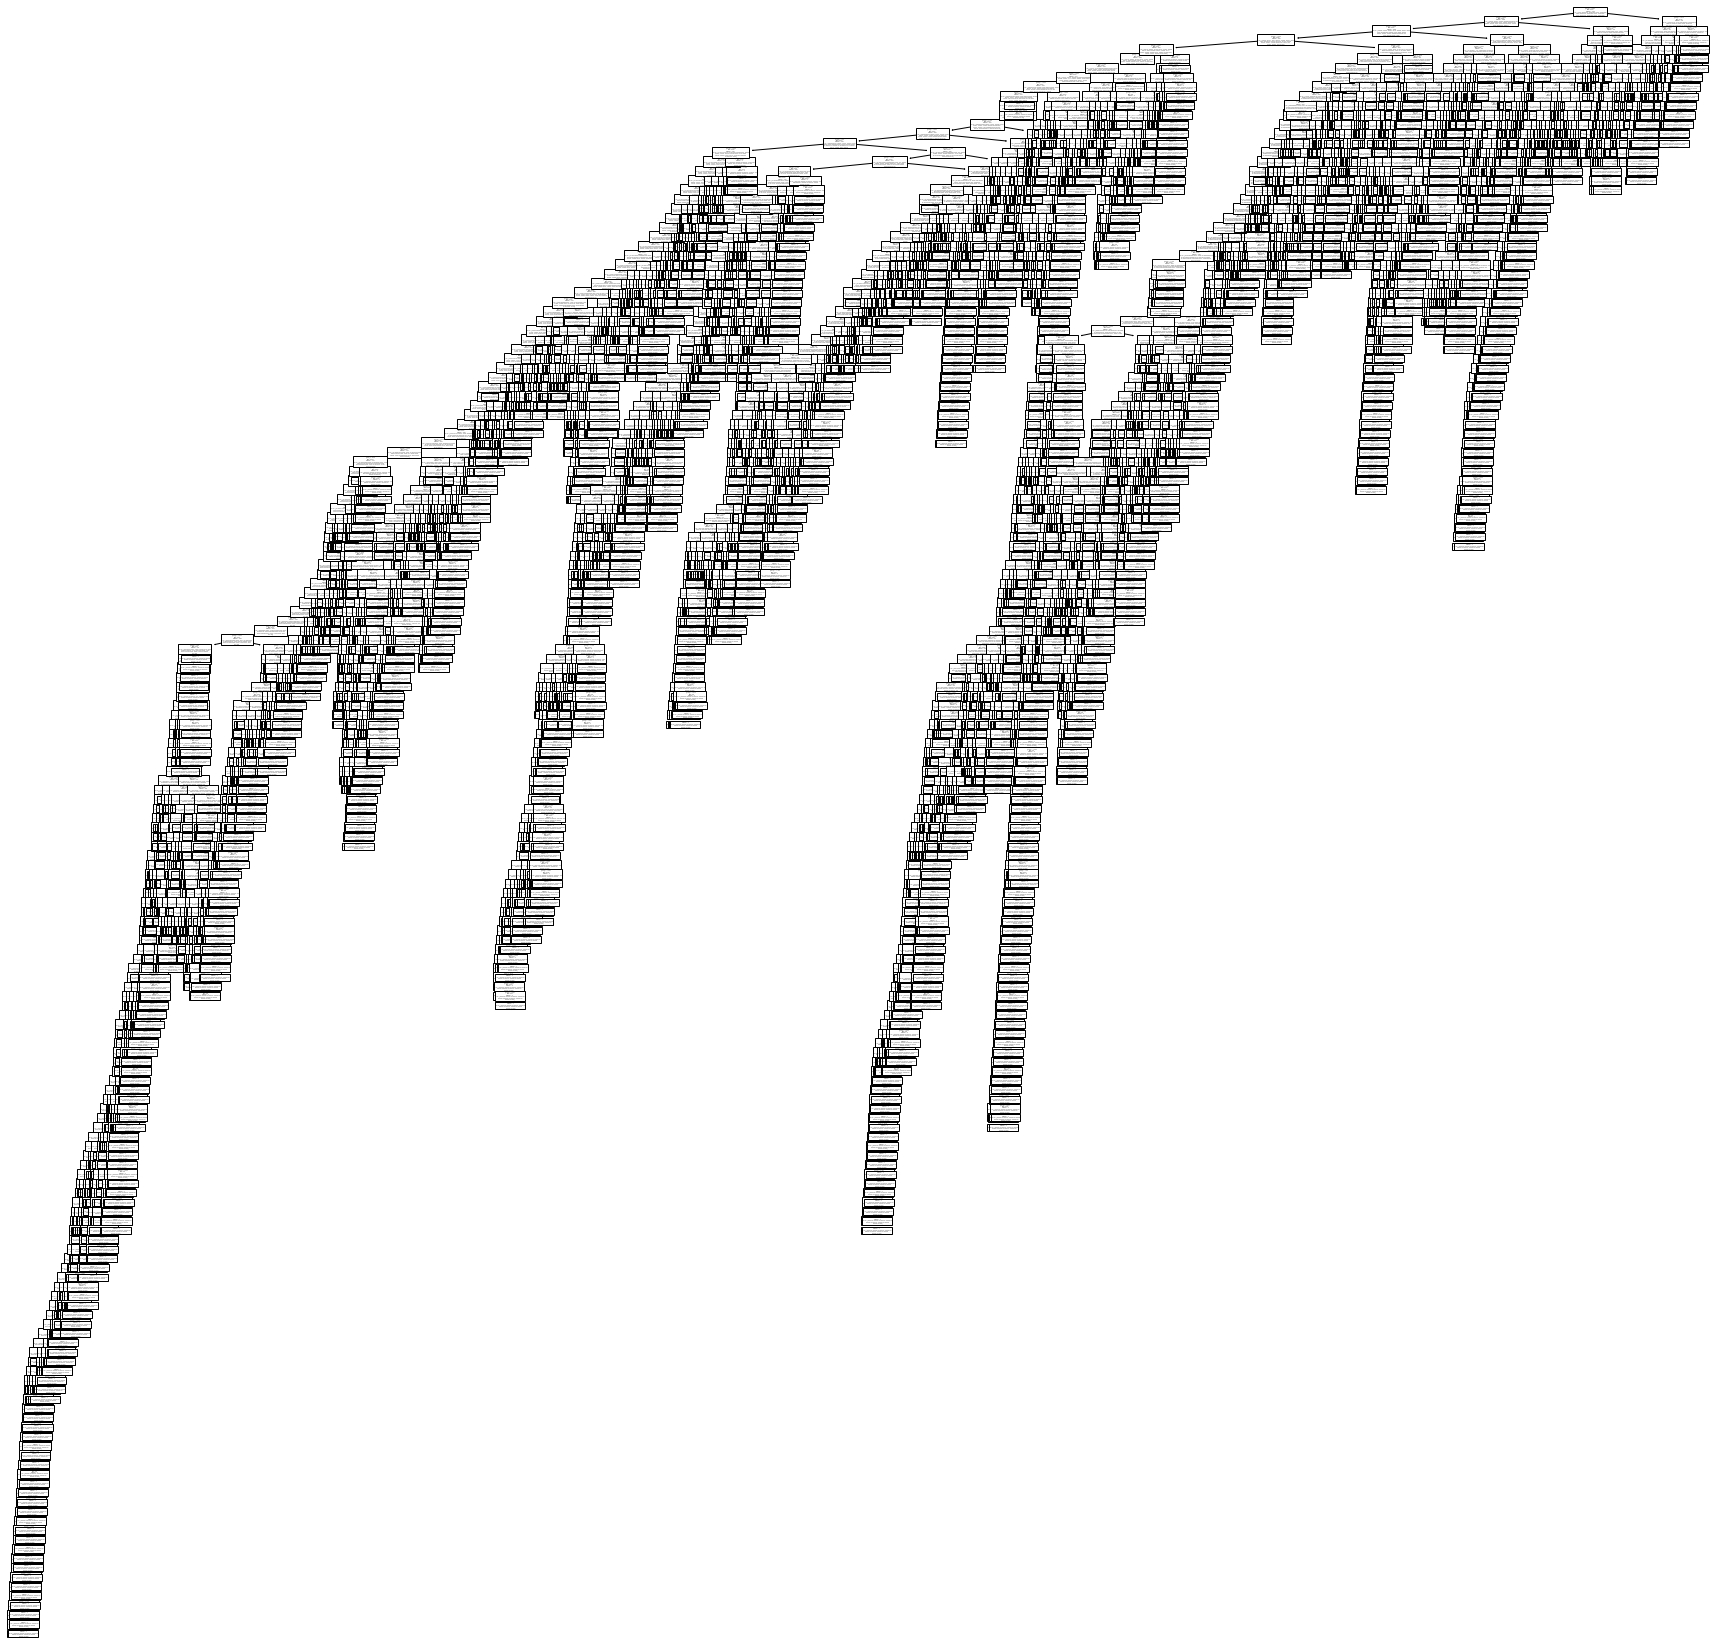

In [56]:
plt.figure(figsize=(30, 30))
tree.plot_tree(i_amA_hardt0_typ3_var1abLe)
plt.show()

0.1659475008989572
0.12998921251348436


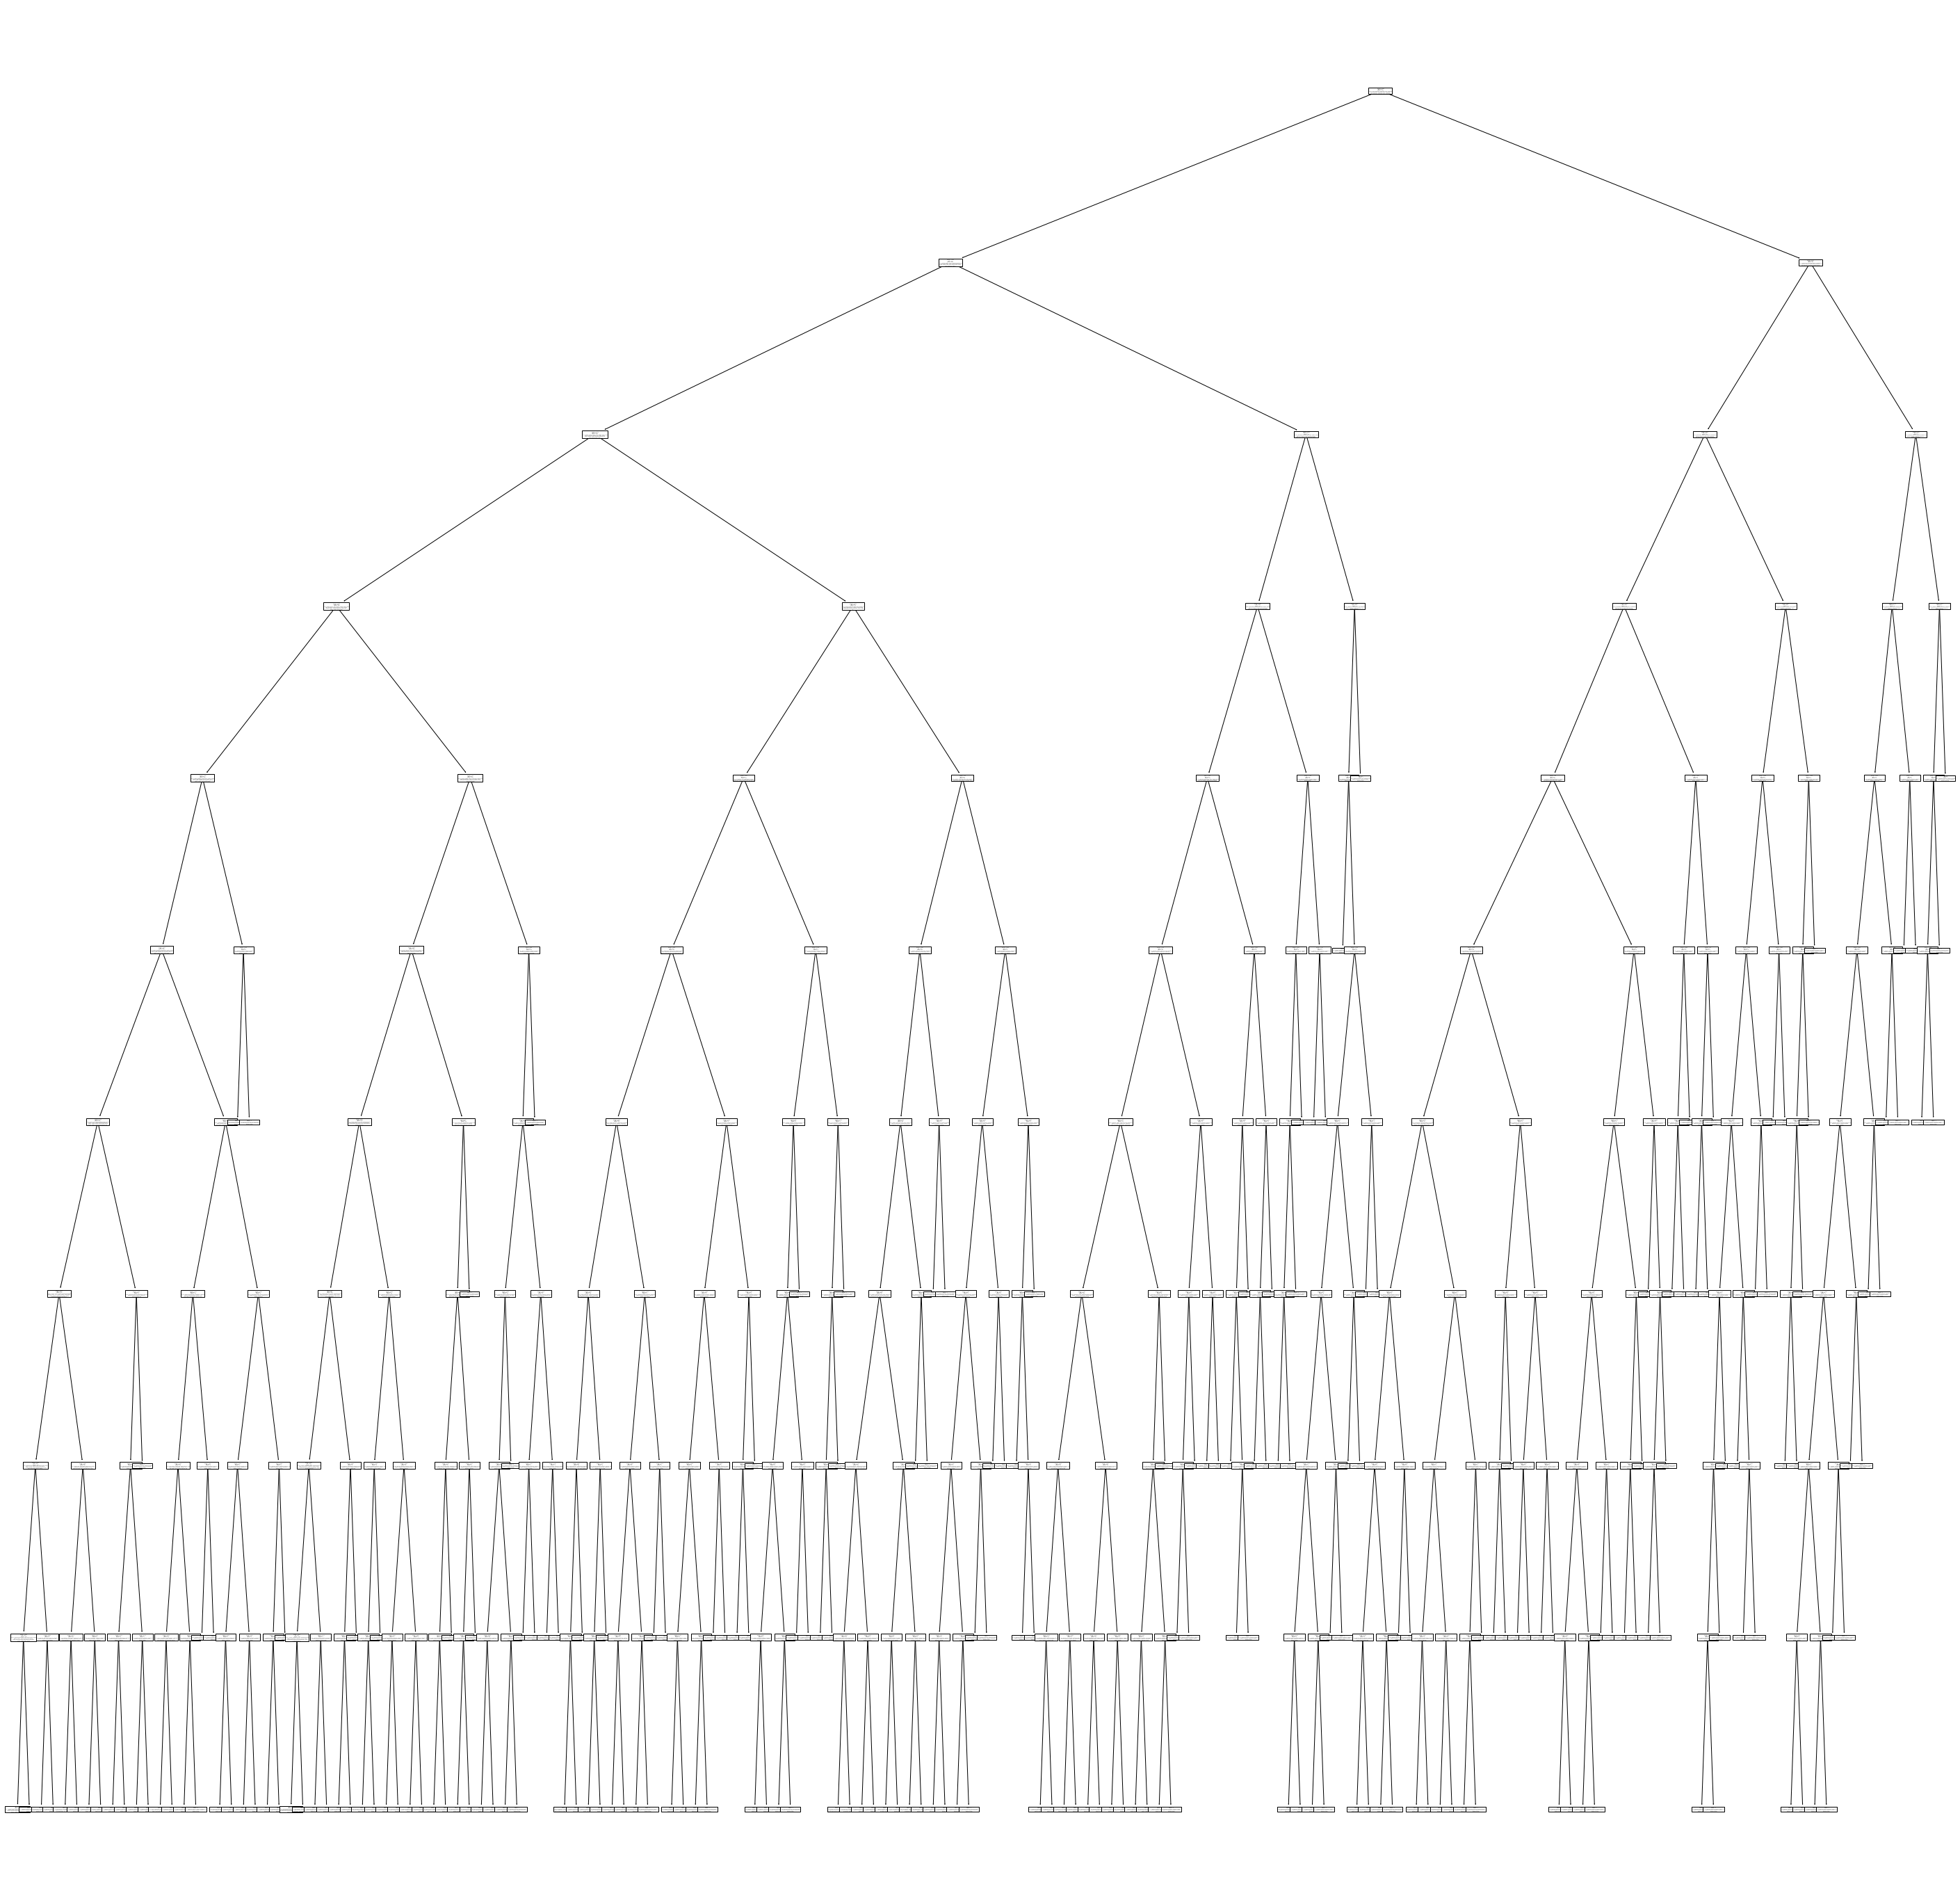

In [65]:
bread_tree = tree.DecisionTreeClassifier(class_weight='balanced', random_state=234, max_depth=10).fit(X_train, y_train)

y_train_bread_tree_predict = bread_tree.predict(X_train)
print(bread_tree.score(X_train, y_train))

y_test_bread_tree_predict = bread_tree.predict(X_test)
print(bread_tree.score(X_test, y_test))

plt.figure(figsize=(50, 50))
tree.plot_tree(bread_tree)
plt.show()

### Start trying a Random Forest Classifier since tweaking a single tree seems like a lot of work with not much payoff

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Paralle

building tree 42 of 100
building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.7s


building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 54 of 100
building tree 55 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    1.1s


building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.3s


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.5s


building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    1.7s


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  59 out of 100 | elapsed:    1.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  65 out of 100 | elapsed:    2.0s remaining:    1.1s


building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  71 out of 100 | elapsed:    2.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  77 out of 100 | elapsed:    2.3s remaining:    0.7s


building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  83 out of 100 | elapsed:    2.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  89 out of 100 | elapsed:    2.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  10 tasks      | e

0.5477346278317152


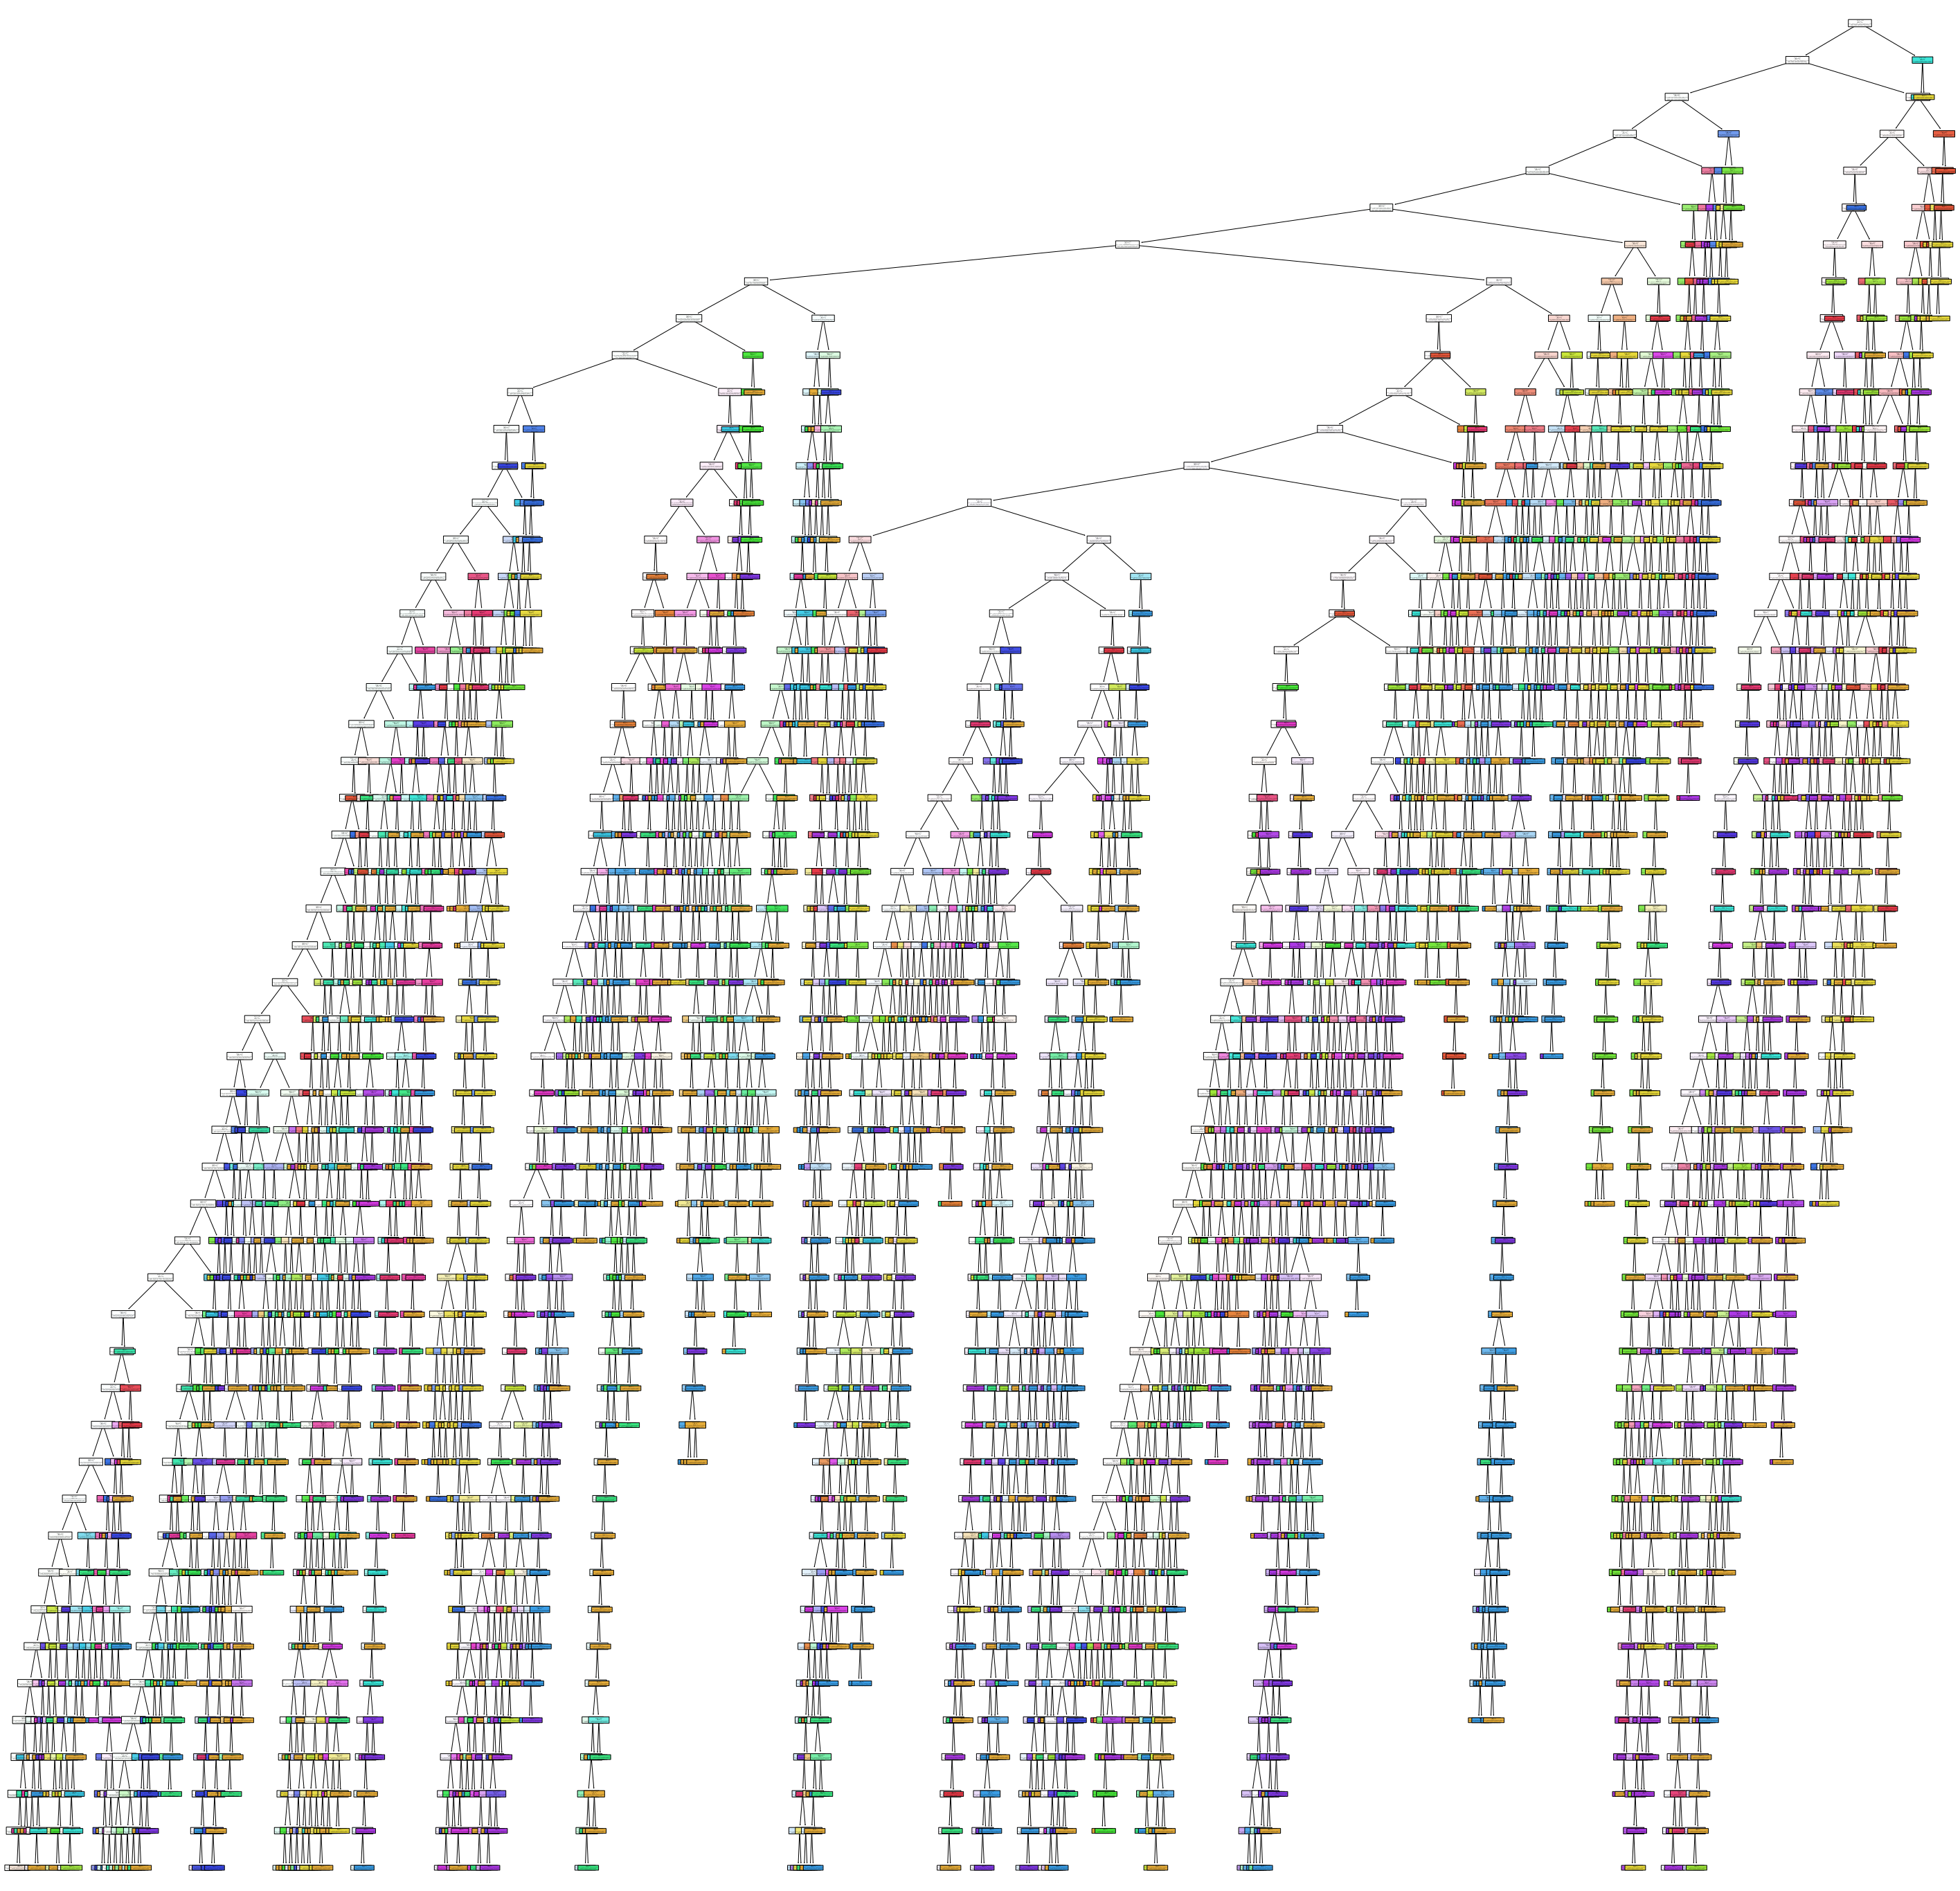

In [68]:
from sklearn.ensemble import RandomForestClassifier

rfc_clf = RandomForestClassifier(max_depth=50, random_state=572, verbose=20, class_weight="balanced", n_jobs=-1)

rfc_clf.fit(X_train, y_train)
print(rfc_clf.score(X_test, y_test))

plt.figure(figsize=(50, 50))
tree.plot_tree(rfc_clf.estimators_[33], filled=True, impurity=True, rounded=True)#, feature_names=X_train.columns, class_names=y_train)
plt.show()

The score is 0.548, and this sounds bad, but according to the sklearn docs, this is a harsh metric to judge on.

Maybe better to just predict the labels and compare

In [72]:
y_test_rfc_predict = rfc_clf.predict(X_test)
print(y_test_rfc_predict.shape)
print(y_test_rfc_predict.tolist())

(3708,)
['American', 'Italian', 'American', 'American', 'American', 'Mexican', 'American', 'Mediterranean', 'Mexican', 'Kosher', 'Italian', 'Asian', 'Italian', 'American', 'Asian', 'Moroccan', 'Italian', 'Italian', 'American', 'American', 'French', 'Italian', 'Mexican', 'French', 'American', 'American', 'American', 'American', 'Italian', 'American', 'French', 'American', 'Asian', 'American', 'American', 'Italian', 'American', 'American', 'Italian', 'American', 'French', 'American', 'Indian', 'Mediterranean', 'American', 'American', 'French', 'Chinese', 'Mediterranean', 'American', 'Asian', 'Thai', 'American', 'Asian', 'Italian', 'American', 'Mediterranean', 'Asian', 'Italian', 'American', 'Italian', 'Italian', 'American', 'American', 'American', 'American', 'American', 'Italian', 'American', 'Asian', 'American', 'Italian', 'Mediterranean', 'American', 'French', 'Asian', 'Asian', 'American', 'American', 'American', 'American', 'Italian', 'Asian', 'American', 'Italian', 'Italian', 'Itali

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  15 tasks      | elaps

In [76]:
zipped_rfc_preds = list(zip(y_test_rfc_predict.tolist(), y_test))
for i in range(0, 19): 
    print(zipped_rfc_preds[i])

('American', 'American')
('Italian', 'Mediterranean')
('American', 'American')
('American', 'American')
('American', 'Scandinavian')
('Mexican', 'American')
('American', 'French')
('Mediterranean', 'American')
('Mexican', 'Mexican')
('Kosher', 'American')
('Italian', 'French')
('Asian', 'Asian')
('Italian', 'American')
('American', 'French')
('Asian', 'Asian')
('Moroccan', 'African')
('Italian', 'French')
('Italian', 'Mediterranean')
('American', 'American')


These mis matches are kinda interesting.

Maybe we can export the words of most importance for each cuisine and/or do PCA or t-SNE on the words to get some sort of visual clustering

In [77]:
type(y_test)

pandas.core.series.Series

In [81]:
y_test_rfc_predict_pd = pd.Series(data=y_test_rfc_predict, index=y_test.index)

In [84]:
potatoes = y_test_rfc_predict_pd.compare(y_test)

In [85]:
potatoes

self          other
30784        Italian  Mediterranean
25209       American   Scandinavian
6104         Mexican       American
1930        American         French
19887  Mediterranean       American
...              ...            ...
27970  Mediterranean   Cajun/Creole
21959        Mexican       American
16557        Italian       American
24188       American         French
10132        Chinese       American

[1677 rows x 2 columns]

In [91]:
len(potatoes.index.tolist())

1677

In [94]:
X_test_incorrect = X_test.loc[potatoes.index.tolist()]

In [95]:
X_test_incorrect

Aioli  Aleppo  Aleppo pepper  Aleppo pepper pepper  Almond  Amaretto  \
30784    0.0     0.0            0.0                   0.0     0.0       0.0   
25209    0.0     0.0            0.0                   0.0     0.0       0.0   
6104     0.0     0.0            0.0                   0.0     0.0       0.0   
1930     0.0     0.0            0.0                   0.0     0.0       0.0   
19887    0.0     0.0            0.0                   0.0     0.0       0.0   
...      ...     ...            ...                   ...     ...       ...   
27970    0.0     0.0            0.0                   0.0     0.0       0.0   
21959    0.0     0.0            0.0                   0.0     0.0       0.0   
16557    0.0     0.0            0.0                   0.0     0.0       0.0   
24188    0.0     0.0            0.0                   0.0     0.0       0.0   
10132    0.0     0.0            0.0                   0.0     0.0       0.0   

       Amaretto almond  Amaretto almond liqueur  Anaheim  Anaheim chile  ...  \
30784              0.0                      0.0      0.0            0.0  ...   
25209              0.0                      0.0      0.0            0.0  ...   
6104               0.0                      0.0      0.0            0.0  ...   
1930               0.0                      0.0      0.0            0.0  ...   
19887              0.0                      0.0      0.0            0.0  ...   
...                ...                      ...      ...            ...  ...   
27970              0.0                      0.0      0.0            0.0  ...   
21959              0.0                      0.0      0.0            0.0  ...   
16557              0.0                      0.0      0.0            0.0  ...   
24188              0.0                      0.0      0.0            0.0  ...   
10132              0.0                      0.0      0.0            0.0  ...   

       zest orange  zest pith  zest vegetable  ziti  zucchini  \
30784          0.0        0.0             0.0   0.0  0.000000   
25209          0.0        0.0             0.0   0.0  0.000000   
6104           0.0        0.0             0.0   0.0  0.215667   
1930           0.0        0.0             0.0   0.0  0.000000   
19887          0.0        0.0             0.0   0.0  0.000000   
...            ...        ...             ...   ...       ...   
27970          0.0        0.0             0.0   0.0  0.000000   
21959          0.0        0.0             0.0   0.0  0.000000   
16557          0.0        0.0             0.0   0.0  0.000000   
24188          0.0        0.0             0.0   0.0  0.000000   
10132          0.0        0.0             0.0   0.0  0.000000   

       zucchini blossom  zucchini crookneck  zucchini squash  árbol  \
30784               0.0                 0.0              0.0    0.0   
25209               0.0                 0.0              0.0    0.0   
6104                0.0                 0.0              0.0    0.0   
1930                0.0                 0.0              0.0    0.0   
19887               0.0                 0.0              0.0    0.0   
...                 ...                 ...              ...    ...   
27970               0.0                 0.0              0.0    0.0   
21959               0.0                 0.0              0.0    0.0   
16557               0.0                 0.0              0.0    0.0   
24188               0.0                 0.0              0.0    0.0   
10132               0.0                 0.0              0.0    0.0   

       árbol pepper  
30784           0.0  
25209           0.0  
6104            0.0  
1930            0.0  
19887           0.0  
...             ...  
27970           0.0  
21959           0.0  
16557           0.0  
24188           0.0  
10132           0.0  

[1677 rows x 3736 columns]

In [96]:
reduced_df.loc[potatoes.index]

id   cuisine_name       variable  Aioli  Aleppo  \
30784  54a477346529d92b2c02afd0  Mediterranean  Mediterranean    0.0     0.0   
25209  54a45db36529d92b2c02461b   Scandinavian   Scandinavian    0.0     0.0   
6104   54a4251c6529d92b2c00ae49       American       American    0.0     0.0   
1930   54a4163d19925f464b375b2a         French         French    0.0     0.0   
19887  54a44ea86529d92b2c01da67       American       American    0.0     0.0   
...                         ...            ...            ...    ...     ...   
27970  54a469816529d92b2c0279de   Cajun/Creole   Cajun/Creole    0.0     0.0   
21959  54a453bf19925f464b38fe75       American       American    0.0     0.0   
16557  54a438f66529d92b2c0196f2       American       American    0.0     0.0   
24188  54a459976529d92b2c0232a2         French         French    0.0     0.0   
10132  54a42c926529d92b2c010b95       American       American    0.0     0.0   

       Aleppo pepper  Aleppo pepper pepper  Almond  Amaretto  Amaretto almond  \
30784            0.0                   0.0     0.0       0.0              0.0   
25209            0.0                   0.0     0.0       0.0              0.0   
6104             0.0                   0.0     0.0       0.0              0.0   
1930             0.0                   0.0     0.0       0.0              0.0   
19887            0.0                   0.0     0.0       0.0              0.0   
...              ...                   ...     ...       ...              ...   
27970            0.0                   0.0     0.0       0.0              0.0   
21959            0.0                   0.0     0.0       0.0              0.0   
16557            0.0                   0.0     0.0       0.0              0.0   
24188            0.0                   0.0     0.0       0.0              0.0   
10132            0.0                   0.0     0.0       0.0              0.0   

       ...  zest orange  zest pith  zest vegetable  ziti  zucchini  \
30784  ...          0.0        0.0             0.0   0.0  0.000000   
25209  ...          0.0        0.0             0.0   0.0  0.000000   
6104   ...          0.0        0.0             0.0   0.0  0.215667   
1930   ...          0.0        0.0             0.0   0.0  0.000000   
19887  ...          0.0        0.0             0.0   0.0  0.000000   
...    ...          ...        ...             ...   ...       ...   
27970  ...          0.0        0.0             0.0   0.0  0.000000   
21959  ...          0.0        0.0             0.0   0.0  0.000000   
16557  ...          0.0        0.0             0.0   0.0  0.000000   
24188  ...          0.0        0.0             0.0   0.0  0.000000   
10132  ...          0.0        0.0             0.0   0.0  0.000000   

       zucchini blossom  zucchini crookneck  zucchini squash  árbol  \
30784               0.0                 0.0              0.0    0.0   
25209               0.0                 0.0              0.0    0.0   
6104                0.0                 0.0              0.0    0.0   
1930                0.0                 0.0              0.0    0.0   
19887               0.0                 0.0              0.0    0.0   
...                 ...                 ...              ...    ...   
27970               0.0                 0.0              0.0    0.0   
21959               0.0                 0.0              0.0    0.0   
16557               0.0                 0.0              0.0    0.0   
24188               0.0                 0.0              0.0    0.0   
10132               0.0                 0.0              0.0    0.0   

       árbol pepper  
30784           0.0  
25209           0.0  
6104            0.0  
1930            0.0  
19887           0.0  
...             ...  
27970           0.0  
21959           0.0  
16557           0.0  
24188           0.0  
10132           0.0  

[1677 rows x 3739 columns]

In [97]:
sheeeeeesh.loc[potatoes.index]

id  \
30784  54a477346529d92b2c02afd0   
25209  54a45db36529d92b2c02461b   
6104   54a4251c6529d92b2c00ae49   
1930   54a4163d19925f464b375b2a   
19887  54a44ea86529d92b2c01da67   
...                         ...   
27970  54a469816529d92b2c0279de   
21959  54a453bf19925f464b38fe75   
16557  54a438f66529d92b2c0196f2   
24188  54a459976529d92b2c0232a2   
10132  54a42c926529d92b2c010b95   

                                                     dek  \
30784  In this recipe we call for a 10 1/2- by 7 1/2-...   
25209  Smoked salmon enhances this innovative version...   
6104                                                       
1930   Nice, being by the sea, offers interesting fis...   
19887                                                      
...                                                  ...   
27970                                                      
21959  Chef Robert Del Grande of Cafe Annie, in Houst...   
16557                                                      
24188  Choucroute — the pickled cabbage that is a cor...   
10132  Boiling this strong coffee with eggshells clar...   

                                                     hed  aggregateRating  \
30784            Spinach, Feta, and Pine-Nut Phyllo Tart             3.64   
25209   Deviled Eggs with Smoked Salmon and Green Onions             3.45   
6104   Southwest Rice and Corn Salad with Lemon Dressing             3.62   
1930                                     Clams au Gratin             1.00   
19887      Summer Rice Salad with Feta, Citrus, and Mint             3.41   
...                                                  ...              ...   
27970                      Creole-Style Oven Hash Browns             3.36   
21959     Short Ribs Braised in Coffee Ancho Chile Sauce             3.50   
16557                Wild Rice with French Green Lentils             3.59   
24188                                  Choucroute Garnie             3.73   
10132                                      Boiled Coffee             3.00   

                                             ingredients  \
30784  [1/2 cup pine nuts (about 3 ounces), 1 medium ...   
25209  [1 8- to 9-ounce russet potato, peeled, cut in...   
6104   [1 cup long-grain white rice, 1/4 cup fresh le...   
1930   [1/2 cup finely chopped mushrooms, 1/2 cup fin...   
19887  [4 cups water, 2 cups uncooked white rice, 1 1...   
...                                                  ...   
27970  [6 large red-skinned potatoes (about 2 1/2 pou...   
21959  [4 dried ancho chiles, stemmed, seeded, and ri...   
16557  [4 1/4 cups water, divided, 1 1/2 teaspoons sa...   
24188  [1 3/4 pounds smoked meaty ham hocks, 1 pound ...   
10132  [10 tablespoons medium-ground full-flavored co...   

                                               prepSteps  reviewsCount  \
30784  [Preheat oven to 375°F., In a shallow baking p...            66   
25209  [Cook potato in pot of boiling salted water un...            20   
6104   [Cook rice until just tender, 12 to 15 minutes...            41   
1930   [Sauté the mushrooms and shallot or onion in 6...             2   
19887  [Bring 4 cups water, rice, and salt to boil in...            21   
...                                                  ...           ...   
27970  [Preheat oven to 400°F. Cook potatoes in mediu...            10   
21959  [Preheat oven to 350°F., Soak ancho chiles in ...            85   
16557  [Bring 2 1/2 cups water and 1 teaspoon salt to...            24   
24188  [Place ham hocks in large saucepan. Add enough...            51   
10132  [Bring all ingredients to a full boil in a lar...             9   

       willMakeAgainPct  cuisine_name                       photo_filename  \
30784                98         Greek  EP_12162015_placeholders_formal.jpg   
25209                90  Scandinavian  EP_12162015_placeholders_casual.jpg   
6104                 97      American  EP_12162015_placeholders_bright.jpg   
1930                  0        French  E

Things we can do:
1. We can get the recipes names and the ingredients in human readable form from the original dataframe and concatenate with the label and predicted labels to see why the mislabels may have predicted what they did
2. Try to see the overlap between the cuisines based off their ingredients using visualizations

In [101]:
from sklearn.manifold import TSNE

SpartanLaser = TSNE(random_state=35, n_jobs=10)
SpartanLaser_tsne = SpartanLaser.fit_transform(X, y)
X_tsne, y_tsne = SpartanLaser_tsne.T

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [102]:
X_tsne

array([ 43.34827 , -14.882807,   9.466188, ..., -12.168884, -52.986862,
       -51.157322], dtype=float32)

In [103]:
y_tsne

array([  6.390477 ,  48.186035 ,   5.7882833, ..., -39.05713  ,
         3.4868755,   8.726667 ], dtype=float32)

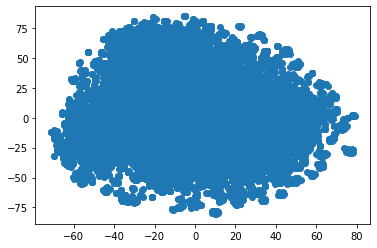

In [104]:
plt.scatter(X_tsne, y_tsne)

In [38]:
repo['ingredients']

NameError: name 'repo' is not defined

In [ ]:
repo['ingredients'][0]

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

train_pred = clf.predict(X_train)

cm = metrics.confusion_matrix(y_train, train_pred, labels=clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
plt.figure(figsize=(40,20))
disp.plot()
plt.show()

In [ ]:
lda_20 = LatentDirichletAllocation(n_components=20, n_jobs=-1, verbose=100, random_state=200)
lda_20_repo_transformed = lda_20.fit_transform(repo_transformed)

In [ ]:
tfidf_lda_20 = LatentDirichletAllocation(n_components=20, n_jobs=-1, verbose=100, random_state=200)
tfidf_lda_20_repo_transformed = tfidf_lda_20.fit_transform(repo_tfidf)

## Manual Topic Labeling Based on LDA

pyLDAvis calls to a deprecated function inside CountVectorizer, which is incompatible with TFIDF. Can we can find an alternate version?